In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numba as nb
from rocket_fft import numpy_like, scipy_like
numpy_like()

matplotlib.rcParams['font.size']=18

In [8]:
def make_grid(N, L, center, **kwargs):
    """
    :param N: список из трех элементов [n_3, n_2, n_1] целых чисел, числа ячеек 
    дискретизации объемной области решения системой прямоугольных параллелепипедов
    :param L: список из трех элементов [l_3, l_2, l_1] вещественных чисел, длины
    дисркетизируемой объемной области решения по каждой из направления декартовой сетки координат
    :param center: список трех элементов [с_3, с_2, с_1] вещественных чисел расположения центра
    объемной области решения в трехмерной системы координат для вариации расположения области решения
    
    :return: (grid, volume), где grid - сетка в трехмерной системе координат с узловыми точками
    прямоугольных ячеек, volume - объем разбиения (прямоугольного параллелепипеда)
     """
    
    # Границы сетки
    x = np.linspace(-L[0]/2 - center[0], L[0]/2 - center[0], N[0] + 1)
    y = np.linspace(-L[1]/2 - center[1], L[1]/2 - center[1], N[1] + 1)
    z = np.linspace(-L[2]/2 - center[2], L[2]/2 - center[2], N[2] + 1)
    
    # Объем ячейки
    h_x = x[1] - x[0]
    h_y = y[1] - y[0]
    h_z = z[1] - z[0]
    volume = h_x * h_y * h_z
    
    # Середины - точки коллокации
    x = (x[1:] + x[:-1])/2
    y = (y[1:] + y[:-1])/2
    z = (z[1:] + z[:-1])/2
    
    # Сетка - трехмерный тензор, вытянутый в строку размером n_3*n_2*n_1
    grid = np.array(np.meshgrid(x, y, z, indexing='ij')).T.reshape(-1, 3)
    
    return grid, volume



def step_dielectric(grid,
                       eps_real,
                       eps_imag,
                       x1_bounds,
                       x2_bounds,
                       x3_bounds):
    """
    grid - Тензор (n_1, n_2, n_3, 3) для каждой точки пространства
    eps_real
    """
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if x1_bounds is None:
        x1_bounds = [-1.0, 0.5]
    if x2_bounds is None:
        x2_bounds = [-1.0, 1.0]
    if x3_bounds is None:
        x3_bounds = [-1.0, 1.0]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0.0j
    indexes = ((grid[:, 0] >= x1_bounds[0]) * (grid[:, 0] <= x1_bounds[1]) *
               (grid[:, 1] >= x2_bounds[0]) * (grid[:, 1] <= x2_bounds[1]) *
               (grid[:, 2] >= x3_bounds[0]) * (grid[:, 2] <= x3_bounds[1]))
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def ellipsis_dielectric(grid,
                           eps_real,
                           eps_imag,
                           center,
                           radius):
    if eps_real is None:
        eps_real = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
    if eps_imag is None:
        eps_imag = [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]
    if center is None:
        center = [0.0, 0.0, 0.0]
    if radius is None:
        radius = [1.0, 1.0, 1.0]
    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = (
        ((grid[:, 0] - center[0]) ** 2) / (radius[0] ** 2) +
        ((grid[:, 1] - center[1]) ** 2) / (radius[1] ** 2) +
        ((grid[:, 2] - center[2]) ** 2) / (radius[2] ** 2)
    ) <= 1
    eps[indexes] = np.array(eps_real) + 1j * np.array(eps_imag)
    return eps, indexes


def apply_dielectric(grid,
                        eps_vec=None, **kwargs):
    if eps_vec is None:
        eps_vec = [
            {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 0.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "ellipsis",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "center": [0.0, 0.0, 0.0],
                "radius": [1.0, 1.0, 1.0]
            }
        ]

    eps = np.zeros((grid.shape[0], 3, 3)) + 0j
    indexes = np.zeros(grid.shape[0], dtype=bool)
    for num, element in enumerate(eps_vec):
        if element.get("type") == "step":
            eps_d, indexes_d = step_dielectric(grid=grid,
                                                  eps_real=element.get('eps_real'),
                                                  eps_imag=element.get('eps_imag'),
                                                  x1_bounds=element.get('x1_bounds'),
                                                  x2_bounds=element.get('x2_bounds'),
                                                  x3_bounds=element.get('x3_bounds'))
        elif element.get("type") == "ellipsis":
            eps_d, indexes_d = ellipsis_dielectric(grid=grid,
                                                      eps_real=element.get('eps_real'),
                                                      eps_imag=element.get('eps_imag'),
                                                      center=element.get('center'),
                                                      radius=element.get('radius'))
        else:
            continue
        indexes += indexes_d
        eps += eps_d
    return eps, indexes


def kernel(x, k=1):
    return np.exp(1j * k * x)/(4 * np.pi * x)

In [9]:
# Функция расчета коэффицентов-матриц дисркетного оператора B
def b_coeff(x, y, k, dv):
    diff = x - y
    R = np.sqrt(np.sum(diff * diff))
    alpha_n = diff / R
    alpha_nm = alpha_n[np.newaxis, :] * alpha_n[:, np.newaxis]
    delta = np.eye(3)
    gr = kernel(R, k)
    coef_1 = ((3/R) * (1/R) - (3 * 1.0j * k) / (R) - (k*k)) * alpha_nm
    coef_2 = ((k*k) + (1.0j * k) / R  - (1/R * 1/R)) * delta
    return gr * dv * (coef_1 + coef_2)


# Заполнение оператора B с матрицами диэлектрической проницаемости среды
def B_eta_operator_matrix(grid, eta, k, volume):
    # Расчет коэффициентов тензора B
    B_matrix = np.zeros((grid.shape[0], grid.shape[0], 3, 3)) + 0.0j
    for i in range(grid.shape[0]-1):
        for j in range(i+1, grid.shape[0]):
            B_matrix[i, j] = b_coeff(grid[i], grid[j], k, volume) @ eta[j]
            B_matrix[j, i] = b_coeff(grid[j], grid[i], k, volume) @ eta[i]

    for i in range(grid.shape[0]):
        B_matrix[i, i] = (-1/3) * np.eye(3) @ eta[i]
    return B_matrix


# Заполнение оператора B без матриц диэлектрической проницаемости среды
def B_operator_matrix(grid, k, volume):
    # Расчет коэффициентов тензора B
    B_matrix = np.zeros((grid.shape[0], grid.shape[0], 3, 3)) + 0.0j
    for i in range(grid.shape[0]-1):
        for j in range(i+1, grid.shape[0]):
            B_matrix[i, j] = b_coeff(grid[i], grid[j], k, volume)
            B_matrix[j, i] = b_coeff(grid[j], grid[i], k, volume)

    for i in range(grid.shape[0]):
        B_matrix[i, i] = (-1/3) * np.eye(3)
    return B_matrix


# Вспомогательная подфункция для программы определения выпуклой оболочки спектра оператора
def cross(o, a, b):
    """
    Возвращает векторное произведение OA и OB
    Положительное значение означает поворот против часовой стрелки
    """
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


# Алгоритм последовательной цепи Эндрю для определения выпуклой оболочки множества точек спектра оператора на комплексной плоскости
def sequential_chain(points):
    """
    :points - список кортежей пар координат точек
    :Функция вычисляет минимальную выпуклую оболочку для заданного множества точек на плоскости
    методом последовательной цепи.
    :Возвращает список точек в порядке обхода оболочки.
    """

    # Сортируем точки лексикографически (по x, затем по y)
    points = sorted(set(points))
    if len(points) == 1:
        return points

    # Строим нижнюю оболочку
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Строим верхнюю оболочку
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # Соединяем верхнюю и нижнюю оболочки
    # Последняя точка каждого списка совпадает с первой точкой другого списка, поэтому исключаем их
    convex = lower[:-1] + upper[:-1]
    return convex


def mu_2points(lambda_1, lambda_2):
    """
    :param lambda_1:
    :param lambda_2:
    :return mu: complex value of circle center on a complex plane
    """
    a = (lambda_1 + lambda_2) / 2
    numerator = 1j * (np.imag(lambda_1 * np.conj(lambda_2)) * (lambda_2 - lambda_1))
    denominator = 2 * (np.abs(lambda_1 * np.conj(lambda_2)) + np.real(lambda_1 * np.conj(lambda_2)))
    mu = a + numerator / denominator
    return mu


def radius_2points(lambda_1, lambda_2):
    """
    :param lambda_1:
    :param lambda_2:
    :return:
    """
    numerator = np.abs(lambda_1 - lambda_2) ** 2 * np.abs(np.conj(lambda_1) * lambda_2)
    denominator = 2 * (np.abs(np.conj(lambda_1) * lambda_2) + np.real(np.conj(lambda_1) * lambda_2))
    radius = np.sqrt(np.real(numerator / denominator))
    return radius


def mu_3points(lambda_1, lambda_2, lambda_3):
    """
    :param lambda_1:
    :param lambda_2:
    :param lambda_3:
    :return:
    """
    numerator = (np.abs(lambda_1) ** 2 * (lambda_2 - lambda_3)
                 +
                 np.abs(lambda_2) ** 2 * (lambda_3 - lambda_1)
                 +
                 np.abs(lambda_3) ** 2 * (lambda_1 - lambda_2))
    denominator = 2 * np.imag(lambda_1 * np.conj(lambda_2)
                              +
                              lambda_2 * np.conj(lambda_3)
                              +
                              lambda_3 * np.conj(lambda_1))
    return 1j * numerator / denominator


def radius_3points(mu, lambda_):
    """

    :param mu:
    :param lambda_:
    :return:
    """
    return abs(mu - lambda_).real


def compute_circle_two_points(lambda_1, lambda_2):
    """

    :param lambda_1:
    :param lambda_2:
    :return:
    """
    center = mu_2points(lambda_1, lambda_2)
    radius = radius_2points(lambda_1, lambda_2)
    return center, radius


def compute_circle_three_points(lambda_1, lambda_2, lambda_3):
    """

    :param lambda_1:
    :param lambda_2:
    :param lambda_3:
    :return:
    """
    x1, y1 = lambda_1.real, lambda_1.imag
    x2, y2 = lambda_2.real, lambda_2.imag
    x3, y3 = lambda_3.real, lambda_3.imag

    d = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

    if np.abs(d) < 1e-12:
        return 1.0+0.0j, 0.0  # Points are colinear or too close

    center = mu_3points(lambda_1, lambda_2, lambda_3)
    radius = radius_3points(center, lambda_1)
    return center, radius


def circle_contains_points(center, radius, points, epsilon = 1e-8):
    """

    :param center:
    :param radius:
    :param points:
    :param epsilon:
    :return:
    """
    return np.prod(np.abs(points - center) <= radius + epsilon) > 0


def circle_contains_origin(center, radius, epsilon = 1e-8):
    """

    :param center:
    :param radius:
    :param epsilon:
    :return:
    """
    return abs(center) <= radius + epsilon


def circle_angle_from_origin(center, radius):
    """

    :param center:
    :param radius:
    :return:
    """
    d = abs(center)
    if d <= radius:
        return np.pi  # Origin is inside the circle
    ratio = radius / d
    ratio = max(-1.0, min(1.0, ratio))  # Clamp to [-1, 1] to avoid math domain error
    theta = 2 * np.arcsin(ratio)
    return theta


def find_params(points):
    """

    :param points:
    :return:
    """
    # Step 1:
    for point1, point2 in np.array(np.meshgrid(points, points)).T.reshape(-1, 2):
        center, radius = compute_circle_two_points(point1, point2)
        if circle_contains_points(center, radius, points):
            print(f"Circle center: {center}, radius: {radius}")
            print(f"Two points, point1: {point1}, point2: {point2}")
            return center, radius,

    # Step 2:
    best_theta = None
    best_circle = None
    for point1, point2, point3 in np.array(np.meshgrid(points, points, points)).T.reshape(-1, 3):
        center, radius = compute_circle_three_points(point1, point2, point3)
        if circle_contains_points(center, radius, points) and \
                not circle_contains_origin(center, radius):
            theta = circle_angle_from_origin(center, radius)
            if best_theta is None or theta < best_theta:
                best_theta = theta
                best_circle = (center, radius)

    if best_circle:
        center, radius = best_circle
        print(f"Circle center: {center}, radius: {radius}")
        return center, radius
    else:
        print("No circle found.")
        return 1.0 + 0.0j, 0.0


# Функция для распаковки тензора (N, N, m, m) -> (N*m, N*m)
def flatten_block_matrix(M4d):
    """
    Раскрывает 4D-блочную матрицу формы (N, N, m, m)
    в большую 2D-матрицу (N*m, N*m).
    """
    N, N2, m, m2 = M4d.shape
    assert N == N2 and m == m2, "Должно быть (N, N, m, m)."
    # Склеиваем оси (N, m) для строк, и (N, m) для столбцов
    return M4d.transpose(0,2,1,3).reshape(N*m, N*m)

In [26]:
# Быстрое умножение блочно-Тёплицевой матрицы на вектор
def fast_bbtmv_mul(col_arr, row_arr, vec_arr):
    """

    :param col_arr:
    :param row_arr:
    :param vec_arr:

    :return:
    """
    
    n_3, n_2, n_1 = col_arr.shape
    
    circulant_tensor = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j
    x_arr = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j

    circulant_tensor[:n_3, :n_2, :n_1] = row_arr[:n_3, :n_2, :n_1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, :n_1] = col_arr[n_3:0:-1, :n_2, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), :n_1] = col_arr[:n_3, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, :n_2, (n_1 + 1):(2*n_1)] = col_arr[:n_3, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), :n_1] = col_arr[n_3:0:-1, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[:n_3, n_2:0:-1, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, n_2:0:-1, n_1:0:-1]

    x_arr[:n_3, :n_2, :n_1] = vec_arr[:n_3, :n_2, :n_1]

    circulant_tensor = np.fft.fftn(circulant_tensor) * np.fft.fftn(x_arr)
    circulant_tensor = np.fft.ifftn(circulant_tensor)

    return circulant_tensor[:n_3, :n_2, :n_1]


# Функция подготовки блочно-Тёплицевой матрицы с (1,1)-элементами в блочно-Циркулянтную матрицу с БПФ
def prep_fftbbmatrix(col_arr, row_arr):
    """
    ПАРАМЕТРЫ
    
    :param col_arr: колонка блочно-Тёлпицевой матрицы размерности (n_3, n_2, n_1)
    :param row_arr: строка блочно-Тёлпицевой матрицы размерности (n_3, n_2, n_1)
    
    ВОЗВРАЩАЕТ
    
    return: циркулянт-тензор блочно-Тёплицевой матрицы размерности (2*n_3, 2*n_2, 2*n_1)
    """
    
    # Размерности тензоров
    n_3, n_2, n_1 = col_arr.shape
    
    # Результирующий циркулянт 
    circulant_tensor = np.zeros((2 * n_3, 2 * n_2, 2 * n_1)) + 0.0j
    
    # Отражения для разширенной дискретизации
    circulant_tensor[:n_3, :n_2, :n_1] = row_arr[:n_3, :n_2, :n_1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, :n_1] = col_arr[n_3:0:-1, :n_2, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), :n_1] = col_arr[:n_3, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, :n_2, (n_1 + 1):(2*n_1)] = col_arr[:n_3, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), :n_1] = col_arr[n_3:0:-1, n_2:0:-1, :n_1]
    circulant_tensor[:n_3, (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[:n_3, n_2:0:-1, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), :n_2, (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, :n_2, n_1:0:-1]
    circulant_tensor[(n_3 + 1):(2*n_3), (n_2 + 1):(2*n_2), (n_1 + 1):(2*n_1)] = col_arr[n_3:0:-1, n_2:0:-1, n_1:0:-1]
    circulant_tensor = np.fft.fftn(circulant_tensor)
    
    return circulant_tensor


# Функция подготовки блочно-Тёплицевого тензора с (3,3)-элементами в блочно-Циркулянтный тензор с БПФ
def prep_fftbbtensor(col_arr, row_arr):
    """
    ПАРАМЕТРЫ
    
    :param col_arr: колонка блочно-Тёлпицевого тензора размерности (n_3, n_2, n_1, 3, 3)
    :param row_arr: строка блочно-Тёлпицевого тензора размерности (n_3, n_2, n_1, 3, 3)
    
    ВОЗВРАЩАЕТ
    
    return: циркулянт-тензор блочно-Тёплицевой матрицы размерности (2*n_3, 2*n_2, 2*n_1, 3, 3)
    """
    
    # Размерности задачи
    n_3, n_2, n_1, _, _ = col_arr.shape
    
    # Результирующий циркулянт-тензор
    result = np.zeros((2*n_3, 2*n_2, 2*n_1, 3, 3)) + 0.0j
    
    # Процесс подготовки тензора
    for row in range(3):
        for col in range(3):
            result[..., row, col] = prep_fftbbmatrix(col_arr[..., row, col], row_arr[..., row, col])
    
    return result


# Фнукция быстрого умножения подготовленного блочно-Циркулянтного БПФ тензора на вектор с ОБПФ
def prep_fbbtmv_ifft(prep_fft_arr, vec_arr):
    """
    ПАРАМЕТРЫ
    
    :param prep_fft_arr: подготовленный БПФ-циркулянт размерности (2*n_3, 2*n_2, 2*n_1)
    :param vec_arr: вектор размерности (n_3, n_2, n_1)
    
    ВОЗВРАЩАЕТ
    return: результат быстрого умножения блочно-Тёплицевой матрицы на вектор размерности (n_3, n_2, n_1)
    """
    # Собираю размерности для результата умножений
    n_3, n_2, n_1 = vec_arr.shape
    
    # Вектор, на который умножаем дополняется нулями в расширенной дискретизации
    x_arr = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j
    
    # Заполнение вектора-операнда в исходной дискретизации
    x_arr[:n_3, :n_2, :n_1] = vec_arr[:n_3, :n_2, :n_1]
    
    # Осуществление умножения и срез необходимого результата
    result = np.fft.ifftn(prep_fft_arr * np.fft.fftn(x_arr))[:n_3, :n_2, :n_1]

    return result


# Фнукция быстрого умножения подготовленного блочно-Циркулянтного БПФ тензора на вектор без ОБПФ
def prep_fbbtmv(prep_fft_arr, vec_arr):
    """
    ПАРАМЕТРЫ
    
    :param prep_fft_arr: подготовленный БПФ-циркулянт размерности (2*n_3, 2*n_2, 2*n_1)
    :param vec_arr: вектор размерности (n_3, n_2, n_1)
    
    ВОЗВРАЩАЕТ
    :return: результат быстрого умножения блочно-Тёплицевой матрицы на вектор размерности (2*n_3, 2*n_2, 2*n_1)
    """
    # Собираю размерности для результата умножений
    n_3, n_2, n_1 = vec_arr.shape
    
    # Вектор, на который умножаем дополняется нулями в расширенной дискретизации
    x_arr = np.zeros((2*n_3, 2*n_2, 2*n_1)) + 0.0j
    
    # Заполнение вектора-операнда в исходной дискретизации
    x_arr[:n_3, :n_2, :n_1] = vec_arr[:n_3, :n_2, :n_1]
    
    # Осуществление умножения и срез необходимого результата
    result = prep_fft_arr * np.fft.fftn(x_arr)

    return result

In [224]:
@nb.njit()
def jit_fft(x):
    return np.fft.fft(x)


@nb.njit()
def jit_ifft(x):
    return np.fft.ifft(x)


# Одномерное умножение по Фурье
@nb.njit()
def t_mult_1d(prep_coeffs_1d, vec, n):
    vec_pad = np.zeros((2*n,)) + 0.0j
    vec_pad[:n] = vec
    vec_pad = jit_fft(vec_pad)
    result = jit_ifft(prep_coeffs_1d * vec_pad)[:n]
    return result
    

@nb.njit()
def t_mult_2d(list_prep_2d, vec_block, n):
    result = np.zeros(vec_block.shape) + 0.0j
    for i in nb.prange(n):
        for j in nb.prange(n):
            block_mult = list_prep_2d[(n-1)+i-j]
            vec_mult = vec_block[j*n:(j+1)*n]
            result[i*n:(i+1)*n] += t_mult_1d(block_mult, vec_mult, n)
    return result


@nb.njit()
def t_mult_3d(list_prep_3d, vec, n):
    result = np.zeros(vec.shape) + 0.0j
    for i in nb.prange(n):
        for j in nb.prange(n):
            block_2d = list_prep_3d[(n-1)+i-j]
            vec_block = vec[j*n*n:(j+1)*n*n]
            result[i*n*n:(i+1)*n*n] += t_mult_2d(block_2d, vec_block, n)
    
    return result


# Слабая реализация алгоритма заполнения массива, 
# для которой нужно иметь при себе 2 * (n*n, n*n*n) данных -----------
@nb.njit()
def prep_coeffs_1dEM(block_row, block_col, n):
    result_array = np.zeros((2*n,)) + 0.0j
    result_array[:n] = block_row[:n]
    result_array[n+1:] = block_col[n:0:-1]
    result_array = jit_fft(result_array)
    return result_array


@nb.njit()
def prep_coeffs_2dEM(block_row, block_col, n):
    coeffs = np.zeros((2*n-1, 2*n)) + 0.0j
    for i in nb.prange(n):
        row_b = prep_coeffs_1dEM(block_row[0, i*n:(i+1)*n], 
                                 block_row[1, i*n:(i+1)*n], n)
        col_b = prep_coeffs_1dEM(block_col[0, i*n:(i+1)*n],
                                 block_col[1, i*n:(i+1)*n], n)
        coeffs[(n-1) - i] = row_b
        coeffs[(n-1) + i] = col_b
    return coeffs


@nb.njit()
def prep_coeffs_3dEM(row_blocks, col_blocks, n):
    coeffs = np.zeros((2*n-1, 2*n-1, 2*n)) + 0.0j
    for i in nb.prange(n):
        row_b = prep_coeffs_2dEM(row_blocks[0, :, i*n*n:(i+1)*n*n], 
                                 row_blocks[1, :, i*n*n:(i+1)*n*n], n)
        col_b = prep_coeffs_2dEM(col_blocks[0, :, i*n*n:(i+1)*n*n],
                                 col_blocks[1, :, i*n*n:(i+1)*n*n], n)
        coeffs[(n-1) + i] = col_b
        coeffs[(n-1) - i] = row_b
    return coeffs


def B_compute(grid1, grid2, volume, n, k, kernel):
    diffs11 = (grid1 - grid2)
    dist11 = np.linalg.norm(diffs11, 2, axis=1)
    
    alpha11 = np.zeros(diffs11.shape) + 0.0j
    alpha11[1:, :] = diffs11[1:, :] / dist11[1:].reshape(-1, 1)
    ind_mat11 = alpha11[:, None, :] * alpha11[:, :, None]
    
    dist_coef_1_11 = np.zeros(dist11.shape) + 0.0j
    dist_coef_1_11[1:] = (3 / (dist11[1:] ** 2)) - ((3j * k) / dist11[1:]) - (k ** 2)
    
    
    dist_coef_2_11 = np.zeros(dist11.shape) + 0.0j
    dist_coef_2_11[1:] = (k ** 2) + ((1j * k) / dist11[1:]) - (1 / (dist11[1:] ** 2))
    
    
    part_1 = ind_mat11 * dist_coef_1_11.reshape(-1, 1, 1)
    part_2 = np.eye(3).reshape(-1, 3, 3) * dist_coef_2_11.reshape(-1, 1, 1)
    
    gr = np.zeros(dist11.shape) + 0.0j
    gr[1:] = kernel(dist11[1:], k)
    
    B_row = gr.reshape(-1, 1, 1) * (part_1 + part_2) * volume
    B_row[0, :, :] = -(1 / 3) * np.eye(3)
    return B_row
    

# Функция для Тёплицевых индексов
def indexes_n(n):
    arr = np.zeros(n*n*n, dtype=int)
    for i in range(n):
        arr[i*n*n:(i+1)*n*n] = np.tile(np.arange(i*n*n, i*n*n + n), n)
    return arr

    
# Функция заполнения элементов тензора коэффициентами задачи
def init_operator_3dEM(grid, volume, eps, n, k, kernel):
    """
    ПАРАМЕТРЫ
    
    :param grid: массив np.ndarray (n*n*n, 3) - трехмерная сетка задачи
    :param volume: вещественное число - объем куба области дискретизации
    :param n: целое число - дискретизации вдоль одной оси
    :param k: вещественное число - волновое число задачи
    :param kernel: функция, рассчитывающая функцию Грина системы
    
    
    ВОЗВРАЩАЕТ 
    :return: 
        B_row(n*n*n, 3,3) - тензор первой строки оператора, 
        B_row_cols(n*n*n, 3,3) - тензор блоков-столбцов при строках оператора,  
        B_col(n*n*n, 3,3) - тензор первого столбца оператора,  
        B_row_cols(n*n*n, 3,3) - тензор блоков-строк при столбце оператора, 
        eps(n*n*n, 3,3) - преобразованный тензор диэлектрической проницаемости задачи
        для постановки задачи
    """
    
    eps = eps.reshape(-1, 3, 3) - (np.eye(3).reshape(-1, 3, 3))
    B_coeffs = np.zeros((2, 2, 2, n * n * n, 3, 3)) + 0.0j
    
    # Блочные строки
    B_coeffs[0, 0, 0] = B_compute(grid[0, :], grid, volume, n, k, kernel)
    B_coeffs[1, 1, 1] = B_compute(grid, grid[0, :], volume, n, k, kernel)
    
    p_ind = np.tile(np.arange(n), n*n)
    q_ind = np.repeat(np.arange(0, n*n*n, n), n)
    B_coeffs[0, 0, 1] = B_compute(grid[p_ind, :], grid[q_ind, :], volume, n, k, kernel)
    B_coeffs[1, 1, 0] = B_compute(grid[q_ind, :], grid[p_ind, :], volume, n, k ,kernel)
    
    p_ind = np.tile(np.repeat(np.arange(0, n*n, n), n), n)
    q_ind = indexes_n(n)
    B_coeffs[0, 1, 0] = B_compute(grid[p_ind, :], grid[q_ind, :], volume, n, k, kernel)
    B_coeffs[1, 0, 1] = B_compute(grid[q_ind, :], grid[p_ind, :], volume, n, k ,kernel)
    
    p_ind = np.tile(np.arange(n*n), n)
    q_ind = np.repeat(np.arange(0, n*n*n, n*n), n*n)
    B_coeffs[0, 1, 1] = B_compute(grid[p_ind, :], grid[q_ind, :], volume, n, k ,kernel)
    B_coeffs[1, 0, 0] = B_compute(grid[q_ind, :], grid[p_ind, :], volume, n, k ,kernel)
    return B_coeffs, eps



def prep_coeffs_3dEM_new(matrix_coeffs_row, matrix_coeffs_col, n):
    """
    ПРИНИМАЕТ
    :param matrix_coeffs_row: numpy ndarray (2,2,n*n*n,3,3) массив посчитанных коэффициентов Тёплицевых блоков 
    верхней строки матрицы B
    :param matrix_coeffs_col: numpy ndarray (2,2,n*n*n,3,3) массив посчитанных коэффициентов Тёплицевых блоков 
    левого столбца матрицы B
    :param n: дискретизация квадратной сетки
    
    ВОЗВРАЩАЕТ
    :return: вложенный список строк B^{F}_{ij} коэффицентов Фурье-преобразования входного тензора коэффициентов B_{ij}
    """
    
    result = []
    row_1 = []
    row_2 = []
    row_3 = []
    
    row_1.append(prep_fftbbmatrix(matrix_coeffs_row[0, 0, :, 0, 0].reshape(n,n,n), 
                                  matrix_coeffs_row[0, 0, :, 0, 0].reshape(n,n,n)))
    row_1.append(prep_coeffs_3dEM(-1 * matrix_coeffs_row[..., 0, 1], 
                                -1 * matrix_coeffs_col[..., 0, 1], n))
    row_1.append(prep_coeffs_3dEM(-1 * matrix_coeffs_row[..., 0, 2], 
                                -1 * matrix_coeffs_col[..., 0, 2], n))
    row_2.append(prep_coeffs_3dEM(-1 * matrix_coeffs_row[..., 1, 0], 
                                -1 * matrix_coeffs_col[..., 1, 0], n))
    row_2.append(prep_fftbbmatrix(matrix_coeffs_row[0, 0, :, 1, 1].reshape(n,n,n), 
                                  matrix_coeffs_row[0, 0, :, 1, 1].reshape(n,n,n)))
    row_2.append(prep_coeffs_3dEM(matrix_coeffs_row[..., 1, 2], 
                                matrix_coeffs_col[..., 1, 2], n))
    row_3.append(prep_coeffs_3dEM(-1 * matrix_coeffs_row[..., 2, 0], 
                                -1 * matrix_coeffs_col[..., 2, 0], n))
    row_3.append(prep_coeffs_3dEM(matrix_coeffs_row[..., 2, 1], 
                                matrix_coeffs_col[..., 2, 1], n))
    row_3.append(prep_fftbbmatrix(matrix_coeffs_row[0, 0, :, 2, 2].reshape(n,n,n),
                                  matrix_coeffs_row[0, 0, :, 2, 2].reshape(n,n,n)))
    
    result.append(row_1)
    result.append(row_2)
    result.append(row_3)
    return result


def mult_toeplitz_3dEM(prep_coeffs, vec, n):
    result = np.zeros(vec.shape) + 0.0j
    
    for i in range(3):
        acc = np.zeros(vec.shape[0]) + 0.0j
        for j in range(3):
            if i == j:
                acc += prep_fbbtmv_ifft(prep_coeffs[i][j], vec[..., j].reshape((n, n, n))).reshape(-1)
            else:
                acc += t_mult_3d(prep_coeffs[i][j], vec[..., j], n)
        result[..., i] = acc
    return result



# Обобщенный метод простой итерации -----------------------------------------------------------

# Оператор для Задачи электродинамики
def operator_3dEM(prep_coeffs, vector_eta, vector_u, n):
    result = np.zeros(vector_u.shape)
    result = np.einsum("...jk,...k->...j", vector_eta, vector_u)
    result = mult_toeplitz_3dEM(prep_coeffs, result, n)
    result = vector_u - result
    return result


# Сопряженный оператор для Задачи электродинамики
def conj_operator_3dEM(conj_coeffs, vector_eta, vector_u, n):
    result = np.zeros(vector_u.shape)
    result = mult_toeplitz_3dEM(conj_coeffs, vector_u, n)
    result = np.einsum("...jk,...k->...j", np.conj(vector_eta), result)
    result = vector_u - result
    return result


# Норма комплексного вектора
def complex_norm(f):
    return np.sqrt(np.sum(f * np.conj(f)).real)


# Обобщенный метод простой итерации на 3д объекте с FFT
def SIM_3dEM(prep_coeffs, vector_f, vector_eta, n, mu=None, u0=None, tol=10e-8, max_iter=20):
    # Списки для сохранения невязок и итераций
    resid_hist = []
    iters_hist = []
    delta_hist = []
    
    # Начальные значения с точки 0
    if u0 is None:
        u0 = np.zeros_like(vector_f) + 0.0j
        
    # Если mu не задан, устанавливаем значение 1
    if mu is None:
        mu = 1.0 + 0.0j
        
    # Подсчет нормы вектора свободных коэффициентов
    norm_f = complex_norm(vector_f)
    
    # Итерации метода
    for it in range(1, max_iter + 1): # k=1,2,...,max_iter
        # Результат вычисления оператора с шагом приближения
        op_res = operator_3dEM(prep_coeffs, vector_eta, u0, n)
        # подсчет невязки
        resid = op_res - vector_f
        # Следующее приближение по итерациям
        u1 = u0 - 1/(mu) * resid
        # Норма невязки
        resid_norm = complex_norm(resid)/norm_f
        # Вычисление дельты приближения
        delta = complex_norm(u1 - u0) / norm_f
        
        # Сохранение исторических значений итераций для графиков
        print(f"Итерация={it}, delta={delta}, resid={resid_norm}")
        resid_hist.append(resid_norm)
        iters_hist.append(it)
        delta_hist.append(delta)
        
        # остановка итераций
        if delta < tol:
            break
        # Копирование вектора
        u0 = np.copy(u1)
        
    return u1, iters_hist, delta_hist, resid_hist


# Стабилизированный метод бисопряженных градиентов --------------------------------------------------------------
def bicg_norm(x):
    return np.sqrt(np.sum(x * np.conj(x)).real)

def bicg_ldot(x, y):
    return np.sum(np.conj(x) * y)

def bicg_rdot(x, y):
    return np.sum(x * y)


def BicgStab(prep_coeffs, vector_f, vector_eta, n, u0=None, tol=10e-8, max_iter=20):
    if max_iter is None:
        max_iter=100
    if u0 is None:
        u0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    norm_f = np.sqrt(complex_norm(vector_f))
    
    
    # Вычислим начальную невязку
    r = vector_f - operator_3dEM(prep_coeffs, vector_eta, u0, n)
    resid_norm = complex_norm(r)/ norm_f
    resid_list.append(resid_norm)
    iters_list.append(1)
    eps_list.append(0)
    
    # Параметры алгоритма
    # Копия начальной невязки для BICG (r tilde)
    r_tilde = r.copy()
    rho_old = 1.0 + 0.0j
    alpha = 1.0 + 0.0j
    omega = 1.0 + 0.0j

    # Векторы p, v обнуляем
    v = np.zeros(vector_f.shape) + 0.0j
    p = np.zeros(vector_f.shape) + 0.0j
    
    # Проверяем, не является ли начальное приближение уже решением
    if resid_norm < tol:
        return vector_u0, iters_list, eps_list, resid_list
    for it in range(1, max_iter+1):
        # Вычисляем скалярное произведение (rho_new = <r_tilde, r>)
        # np.vdot учитывает комплексное сопряжение первого аргумента
        rho_new = bicg_ldot(r_tilde, r)
        
        # Если rho_new близко к 0, алгоритм может потерять устойчивость
        if abs(rho_new) < 1e-15:
            # Полагаем, что метод не может продолжаться
            return vector_u0, iters_list, eps_list, resid_list
        
        beta = (rho_new / rho_old) * (alpha / omega)
        rho_old = rho_new * 1.0
    
        # Обновляем направление p
        p = r + beta * (p - omega * v)
        
        # Считаем v = A * p
        v = operator_3dEM(prep_coeffs, vector_eta, p, n)
        
        # alpha = rho_new / <r_tilde, v>
        denom = bicg_ldot(r_tilde, v)
        if abs(denom) < 1e-15:
            print('Метод вырождается')
            return u0, iters_list, eps_list, resid_list
        alpha = rho_new / denom
        
        # Новая невязка s
        s = r - alpha * v
        
        # Проверяем остаток (s)
        norm_s = bicg_norm(s)
        if norm_s < tol:
            print('достичь нужной точности смогли быстрее')
            uk = u0 + alpha * p
            return uk, iters_list, eps_list, resid_list 
        
        # t = A*s
        t = operator_3dEM(prep_coeffs, vector_eta, s, n)
        
        # omega = <t, s> / <t, t>
        denom_ts = bicg_rdot(t, t)
        if abs(denom_ts) < 1e-15:
            print('Метод вырождается')
            return uk, iters_list, eps_list, resid_list
        omega = bicg_rdot(t, s) / denom_ts
        
        # Обновляем решение
        uk = u0 + alpha * p + omega * s
        
        # Обновляем невязку
        r = s - omega * t
        
        # Проверяем условие останова по невязке
        norm_r = bicg_norm(r)/ norm_f
        eps = bicg_norm(uk - u0) / norm_f
        eps_list.append(eps)
        resid_list.append(norm_r)
        iters_list.append(iters_list[-1] + 2)
        print(f'Итерация №{it}: Умножений М-В L = {3 + 2 * it}, Умножений В-В V = {2 + 2 * it}, Критерий останова eps = {eps}, Невязка resid = {resid_list[-1]}')
        if eps < tol:
            return uk, iters_list, eps_list, resid_list  # решение найдено с нужной точностью
        
        # Если omega близко к 0, то есть риск деления на ноль на следующем шаге
        if abs(omega) < 1e-15:
            # Метод зашёл в тупик
            return uk, iters_list, eps_list, resid_list
        
        u0 = uk * 1.0
    # Если цикл закончился без достижения точности, возвращаем x и число итераций
    return uk, iters_list, eps_list, resid_list



# Двухшаговый метод градиентного спуска -------------------------------------------------------------------------
def TwoStep(prep_coeffs, conj_coeffs, vector_f, vector_eta, n, u0=None, tol=10e-8, max_iter=20):
    
    if max_iter is None:
        max_iter=100
    if u0 is None:
        u0 = np.zeros(vector_f.shape) + 0.0j
    
    # Логи итераций
    iters_list = []
    eps_list = []
    resid_list = []
    
    # Норма вектора свободных коэффициентов
    f_norm = np.sqrt(complex_norm(vector_f))
    
    # Итерационный процесс
    l_0 = operator_3dEM(prep_coeffs, vector_eta, u0, n)
    r_0 = l_0 - vector_f
    l_1 = conj_operator_3dEM(conj_coeffs, vector_eta, r_0, n)
    l_2 = operator_3dEM(prep_coeffs, vector_eta, l_1, n)
    u1 = u0 - complex_norm(l_1) / complex_norm(l_2) * l_1
    
    # Расчет критерия останова
    eps = np.sqrt(complex_norm(u1 - u0)) / f_norm
    
    # Пополнение списков для логов итераций
    iters_list.append(3)
    eps_list.append(eps)
    resid_list.append(complex_norm(r_0)/f_norm)
    print(f'Итерация №1: Умножений М-В L = {iters_list[-1]}, Умножений В-В V = {4}, Критерий останова eps = {eps_list[-1]}')
    if (eps < tol):
        return z_1, iters_list, eps_list, resid_list 
    
    # Цикл, если 
    for it in range(2, max_iter+1):
        l_0 = operator_3dEM(prep_coeffs, vector_eta, u1, n)
        r_k = l_0 - vector_f
        l_1 = conj_operator_3dEM(conj_coeffs, vector_eta, r_k, n)
        l_2 = operator_3dEM(prep_coeffs, vector_eta, l_1, n)
        
        delta_rk = r_k - r_0
        a_0 = complex_norm(delta_rk)
        a_1 = complex_norm(l_1)
        a_2 = complex_norm(l_2)
        
        det = (a_0 * a_2 - a_1 * a_1)
        t_k = -(a_1 * a_1) / det
        h_k = (a_0 * a_1) / det
        
        uk = u1 - t_k * (u1 - u0) - h_k * l_1
        
        eps = np.sqrt(complex_norm(uk - u1)) / f_norm 
        
        iters_list.append(iters_list[-1] + 3)
        eps_list.append(eps)
        resid_list.append(complex_norm(r_k)/f_norm)

        print(f'Итерация №{it}: Умножений М-В L = {iters_list[-1]}, \nУмножений В-В V = {it*4}, \nКритерий останова eps = {eps_list[-1]},\nНевязка итераций resid={resid_list[-1]}\n')
        if (eps < tol):
            break
        
        r_0 = np.copy(r_k)
        u0 = np.copy(u1)
        u1 = np.copy(uk)
    return uk, iters_list, eps_list, resid_list

In [37]:
def wave(x, k=1, orient=[0.0, 0.0, 1.0], sign=1, amplitude=[1.0, 0.0, 0.0], phi0=0.0, **kwargs):
    orient = np.array(orient) / np.linalg.norm(np.array(orient), 2)
    amplitude = np.array(amplitude)
    return amplitude.reshape(-1, 3) * np.exp(sign * 1j * k * (x.dot(orient)) - phi0).reshape(-1, 1)

In [48]:
def compute_RCS(result_s, eps_on_grid, grid, in_Q, volume, k_0, n_phi):
    epsilon = 1e-6
    angles = np.linspace(-np.pi+epsilon, np.pi-epsilon, n_phi)
    vectors_xy = np.hstack([
        np.cos(angles).reshape((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1)),    
        np.zeros((n_phi, 1))
        ])
    vectors_yz = np.hstack([
        np.zeros((n_phi, 1)),
        np.cos(angles).reshape((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1))
        ])
    vectors_xz = np.hstack([
        np.cos(angles).reshape((n_phi, 1)),
        np.zeros((n_phi, 1)),
        np.sin(angles).reshape((n_phi, 1)),
        ])
    result_list = []
    angles_list = []
    for vectors in [vectors_xy, vectors_yz, vectors_xz]:
        s_q = np.einsum('...ji,...i->...j', eps_on_grid-np.eye(3).reshape(-1, 3, 3), result_s)
        cross_matrix_e_r = np.einsum("...ij,...kj->...ik", grid, vectors)
        waves = np.exp(1j * k_0 * cross_matrix_e_r) * (in_Q.reshape(-1, 1) * volume)
        result = np.einsum('...ij,...ik->jk', waves, s_q)
        result = (k_0**4) / (16 * np.pi**2) * np.power(np.linalg.norm(np.cross(vectors, result), 2, axis=1), 2)
        result_list.append(result)
        angles_list.append(angles)
    return result_list, angles_list

In [236]:
# Конфиг задачи
problem_config = {
    'N': [30, 30, 30],
    'L': [1.0, 1.0, 1.0],
    'center': [0.0, 0.0, 0.0],
    'k': 2.0,
    'orient': [0.0, 1.0, 0.0],
    'amplitude': [1.0, 0.0, 0.0],
    'sign': 1.0,
    'eps_vec': [
        {
                "type": "step",
                "eps_real": [[1.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0],
                             [0.0, 0.0, 1.0]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-1.0, 1.0],
                "x2_bounds": [-1.0, 1.0],
                "x3_bounds": [-1.0, 1.0]
            },
            {
                "type": "step",
                "eps_real": [[5.5, 0.0, 0.0],
                             [0.0, 5.5, 0.0],
                             [0.0, 0.0, 5.5]],
                "eps_imag": [[0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0]],
                "x1_bounds": [-0.6, 0.6],
                "x2_bounds": [-0.6, 0.6],
                "x3_bounds": [-0.6, 0.6]
            }
    ]
}



# Размерность задачи
N = problem_config.get("N")

# Настройки быстрого умножения
n_1 = N[0]
n_2 = N[1]
n_3 = N[2]

# Размерность меньшей задачи на сетке для расчета параметра
factor_low = 5
N_low = [n//factor_low for n in N]
n_1_low = N_low[0]
n_2_low = N_low[0]
n_3_low = N_low[0]

to_reshape = tuple(N[::-1])
to_reshape_grid = tuple(N[::-1]+[3])
to_reshape_tensor = tuple(N[::-1]+[3, 3])

# Объем области Q
L = problem_config.get("L")

# Центр области Q
center = problem_config.get("center")

# Задание индекса eta(x) для точек внутри Q 
eps_vec = problem_config.get("eps_vec")

# Волновое число задачи
k=problem_config.get("k")

In [237]:
# Расчет сетки дискретизации
grid_low, volume_low = make_grid(N = N_low, 
                                 L = L, 
                                 center = center)

# Расчет расстояний на сетке дискретизации
dists_low = np.linalg.norm(grid_low[0] - grid_low, axis=1)

# Ассоциация точкам сетки диэлектрической проницаемости
eta_low, ind_low = apply_dielectric(grid_low, eps_vec)
eta_low = eta_low - np.eye(3)[np.newaxis, :, :]

# Расчет блочной операторной матрицы B 
B_matrix = B_eta_operator_matrix(grid_low, eta_low, k, volume_low)

# Вычитаем единичную матрицу из B*eta
Bt = np.eye(np.prod(N_low) * 3) - flatten_block_matrix(B_matrix)

# Расчет собственных значений оператора встроенной программой
result_eigs = np.linalg.eigvals(Bt)

# Список собственных значений матричного оператора
print("Собственные значения матрицы оператора")
print(result_eigs[-n_1_low:])

Собственные значения матрицы оператора
[1.56998133+0.01076223j 1.49887737+0.01069828j 1.40203009+0.01070971j
 1.47546497+0.01071769j 1.41375007+0.01080316j 2.75715856+0.01073961j]


In [238]:
# Поиск выпуклой оболочки спектрального множества
list_of_points = [(x.real, x.imag) for x in result_eigs]
hull = sequential_chain(list_of_points)
hull_eigs = np.array([x[0] + 1.0j * x[1] for x in hull])
print("\nВыпуклая оболочка спектра", hull_eigs)

# Центр и радиус для параметров итерационного метода
mu, radius = find_params(hull_eigs)
# Оценка сходимости
rho = np.arctan(radius/np.abs(mu))/2

print("\nЦентр окружности", mu)
print("Радиус окружности", radius)
print("Знаменатель сходимости", rho)


Выпуклая оболочка спектра [0.10697363-0.25574313j 0.10697363-0.25574313j 1.56962187-1.37115983j
 6.78806659+0.01080681j 4.79606452+0.01080682j 3.9870605 +0.01080682j
 3.26291108+0.01080682j 1.49020218+0.01080682j 0.7285503 +0.01080682j
 0.6564764 +0.01080675j 0.65544639+0.01080522j 0.65544639+0.01080522j
 0.58475519-0.00676609j]
Circle center: (3.536390643190356-2.350014259706075j), radius: 4.018317132451993
Two points, point1: (0.10697363429118666-0.25574313207472654j), point2: (6.788066587499577+0.010806811480376724j)

Центр окружности (3.536390643190356-2.350014259706075j)
Радиус окружности 4.018317132451993
Знаменатель сходимости 0.3789267487913587


In [239]:
# Краткая статистика по спектру
minRe = np.min(result_eigs.real) 
maxRe = np.max(result_eigs.real)
minIm = np.min(result_eigs.imag)
maxIm = np.max(result_eigs.imag)
print(r"Минимальное вещественное значение $min Re \sigma$=" + f"{minRe.round(4)}")
print(r"Максимальное вещественное значение $max Re \sigma$=" + f"{maxRe.round(4)}")
print(r"Минимальное мнимое значение $min Im \sigma$=" + f"{minIm.round(4)}")
print(r"Максимальное мнимое значение $min Im \sigma$=" + f"{maxIm.round(4)}")

Минимальное вещественное значение $min Re \sigma$=0.107
Максимальное вещественное значение $max Re \sigma$=6.7881
Минимальное мнимое значение $min Im \sigma$=-1.3712
Максимальное мнимое значение $min Im \sigma$=0.0108


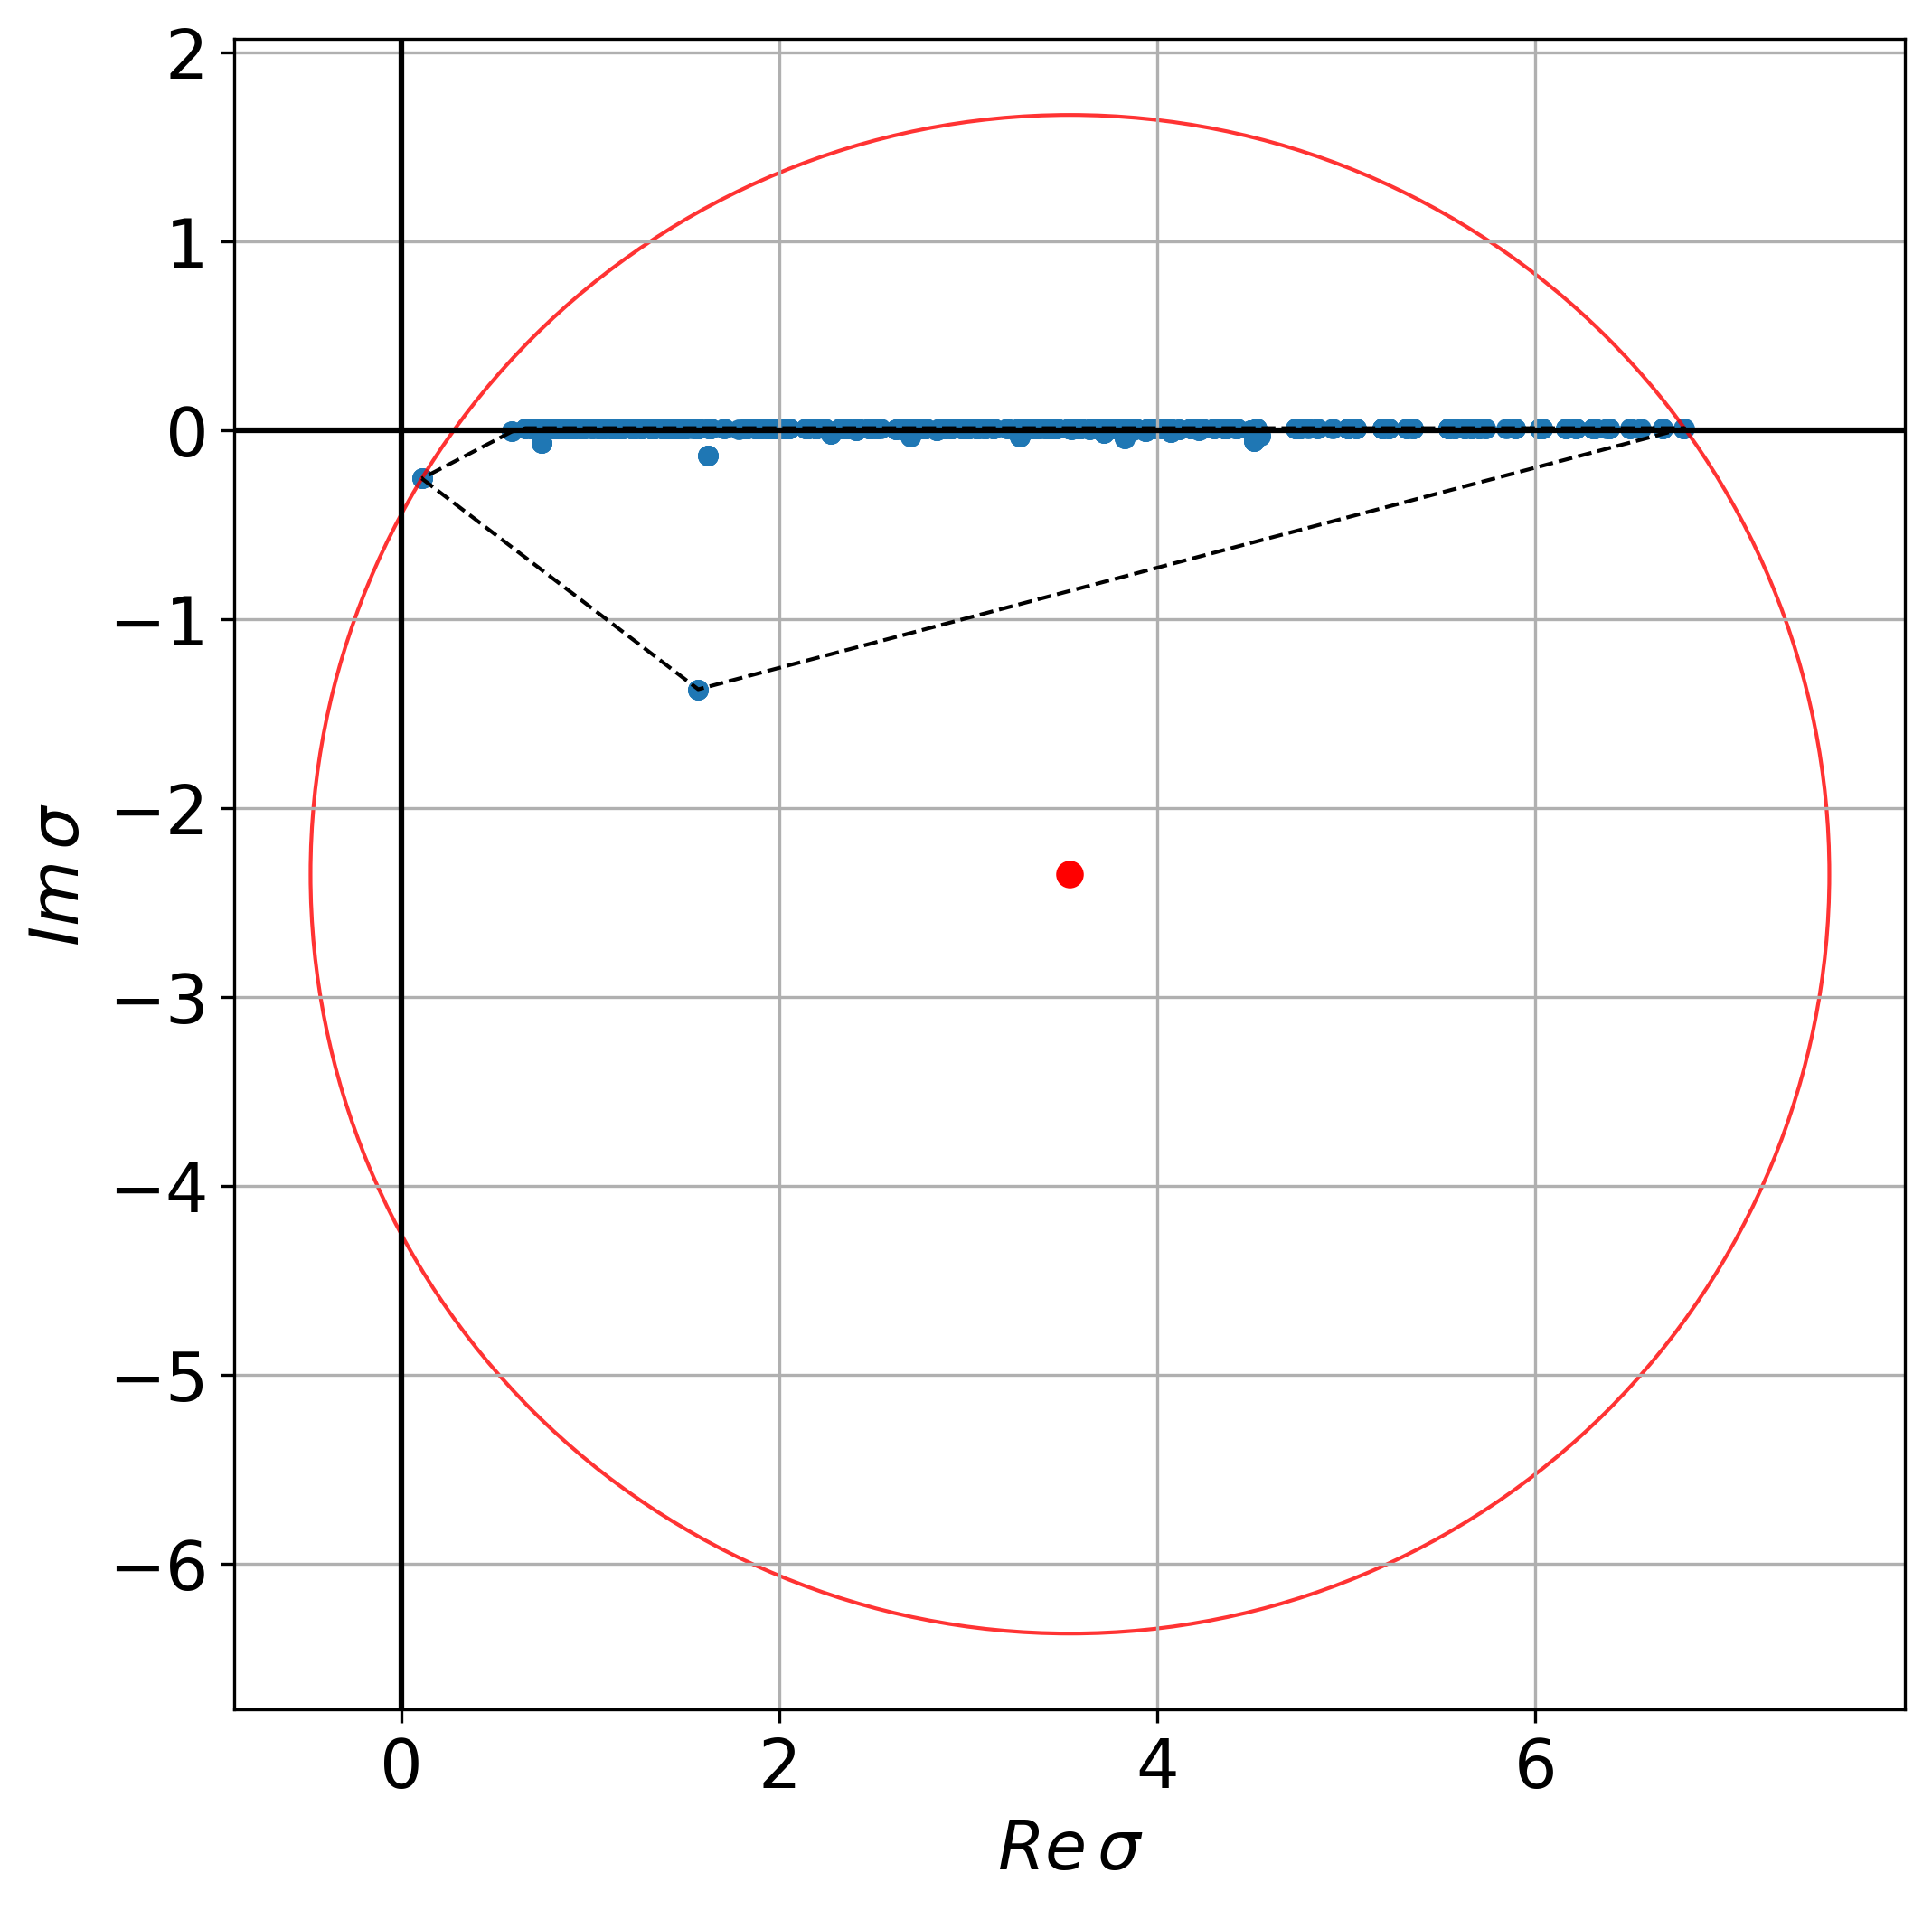

In [240]:
# Задание графика на холсте
plt.figure(figsize=(8,8), dpi=300)
plt.gca().set_aspect('equal')

# Визуализация спектра оператора на комплексной плоскости
plt.scatter(result_eigs.real, result_eigs.imag,s=20, label = r"$\sigma$")
#plt.xlim((-max(maxRe, maxIm)/4, max(maxRe, maxIm) + 1))   # Границы отрисовки
#plt.ylim((-max(maxRe, maxIm), max(maxRe, maxIm)))      # Границы отрисовки

# Визуализация выпуклой оболочки спектра
plt.plot(hull_eigs.real, hull_eigs.imag, c="black", linestyle="--", linewidth=1, label="hull")
plt.plot(hull_eigs.real[[-1, 0]], hull_eigs.imag[[-1, 0]], c="black", linestyle="--", linewidth=1)
plt.scatter([mu.real], [mu.imag], color="r", s=40, )
circle1 = plt.Circle((mu.real, mu.imag), radius, color='r', fill=False, alpha=0.8, label="($\mu$, R)")
plt.gca().add_patch(circle1)

plt.axvline(0, color="black")
plt.axhline(0, color="black")

plt.xlabel(r"$Re\,\sigma$")
plt.ylabel(r"$Im\,\sigma$")

plt.grid()
#plt.legend()
plt.show()

# Решение на большой сетке

In [222]:
amplitude = problem_config.get('amplitude')
orient = problem_config.get('orient')

grid, volume = make_grid(**problem_config)
eta, ind = apply_dielectric(grid, **problem_config)
f_wave = wave(grid, k, orient, 1, amplitude)

B_tensor, eta = init_operator_3dEM(grid, volume, eta, n_1, k, kernel)
coeffs_3d = prep_coeffs_3dEM_new(B_tensor[0], 
                                 B_tensor[1], n_1)
conj_coeffs_3d = prep_coeffs_3dEM_new(np.conj(B_tensor[0]), 
                                 np.conj(B_tensor[1]), n_1)

In [225]:
result_BS, iters_BS, delta_BS, resid_BS = BicgStab(coeffs_3d, f_wave, eta, n_1, max_iter=20)

Итерация №1: Умножений М-В L = 5, Умножений В-В V = 4, Критерий останова eps = 6.510475880695817
Итерация №2: Умножений М-В L = 7, Умножений В-В V = 6, Критерий останова eps = 3.5960578359550324
Итерация №3: Умножений М-В L = 9, Умножений В-В V = 8, Критерий останова eps = 48.888888621823625
Итерация №4: Умножений М-В L = 11, Умножений В-В V = 10, Критерий останова eps = 33.73961757590519
Итерация №5: Умножений М-В L = 13, Умножений В-В V = 12, Критерий останова eps = 1.825217411013348
Итерация №6: Умножений М-В L = 15, Умножений В-В V = 14, Критерий останова eps = 1.3964572308336018
Итерация №7: Умножений М-В L = 17, Умножений В-В V = 16, Критерий останова eps = 1.4450913746680882
Итерация №8: Умножений М-В L = 19, Умножений В-В V = 18, Критерий останова eps = 1.5235869421787598
Итерация №9: Умножений М-В L = 21, Умножений В-В V = 20, Критерий останова eps = 0.3637010552161193
Итерация №10: Умножений М-В L = 23, Умножений В-В V = 22, Критерий останова eps = 0.0404106443567546
Итерация

In [241]:
result_EM, iters_EM, delta_EM, resid_EM = SIM_3dEM(coeffs_3d, f_wave, eta, n_1, mu, max_iter=40)

Итерация=1, delta=0.23551506236006636, resid=1.0
Итерация=2, delta=0.14251684569055623, resid=0.6051283695506058
Итерация=3, delta=0.11170180683300833, resid=0.4742873161217749
Итерация=4, delta=0.09437497359177197, resid=0.4007173581428397
Итерация=5, delta=0.08390075568344678, resid=0.3562436934720354
Итерация=6, delta=0.07781131410784697, resid=0.33038784580531594
Итерация=7, delta=0.07356055899345194, resid=0.3123390846271613
Итерация=8, delta=0.07011100166200528, resid=0.2976922195949248
Итерация=9, delta=0.06716987974696716, resid=0.28520417791484914
Итерация=10, delta=0.06459194988724466, resid=0.27425825439773144
Итерация=11, delta=0.0622767024854015, resid=0.26442768399326405
Итерация=12, delta=0.06015723598168872, resid=0.25542840181371307
Итерация=13, delta=0.058188028275733654, resid=0.24706712043229362
Итерация=14, delta=0.056340970624541166, resid=0.2392244897628012
Итерация=15, delta=0.0545972675794688, resid=0.23182070408727387
Итерация=16, delta=0.05293829272020751, re

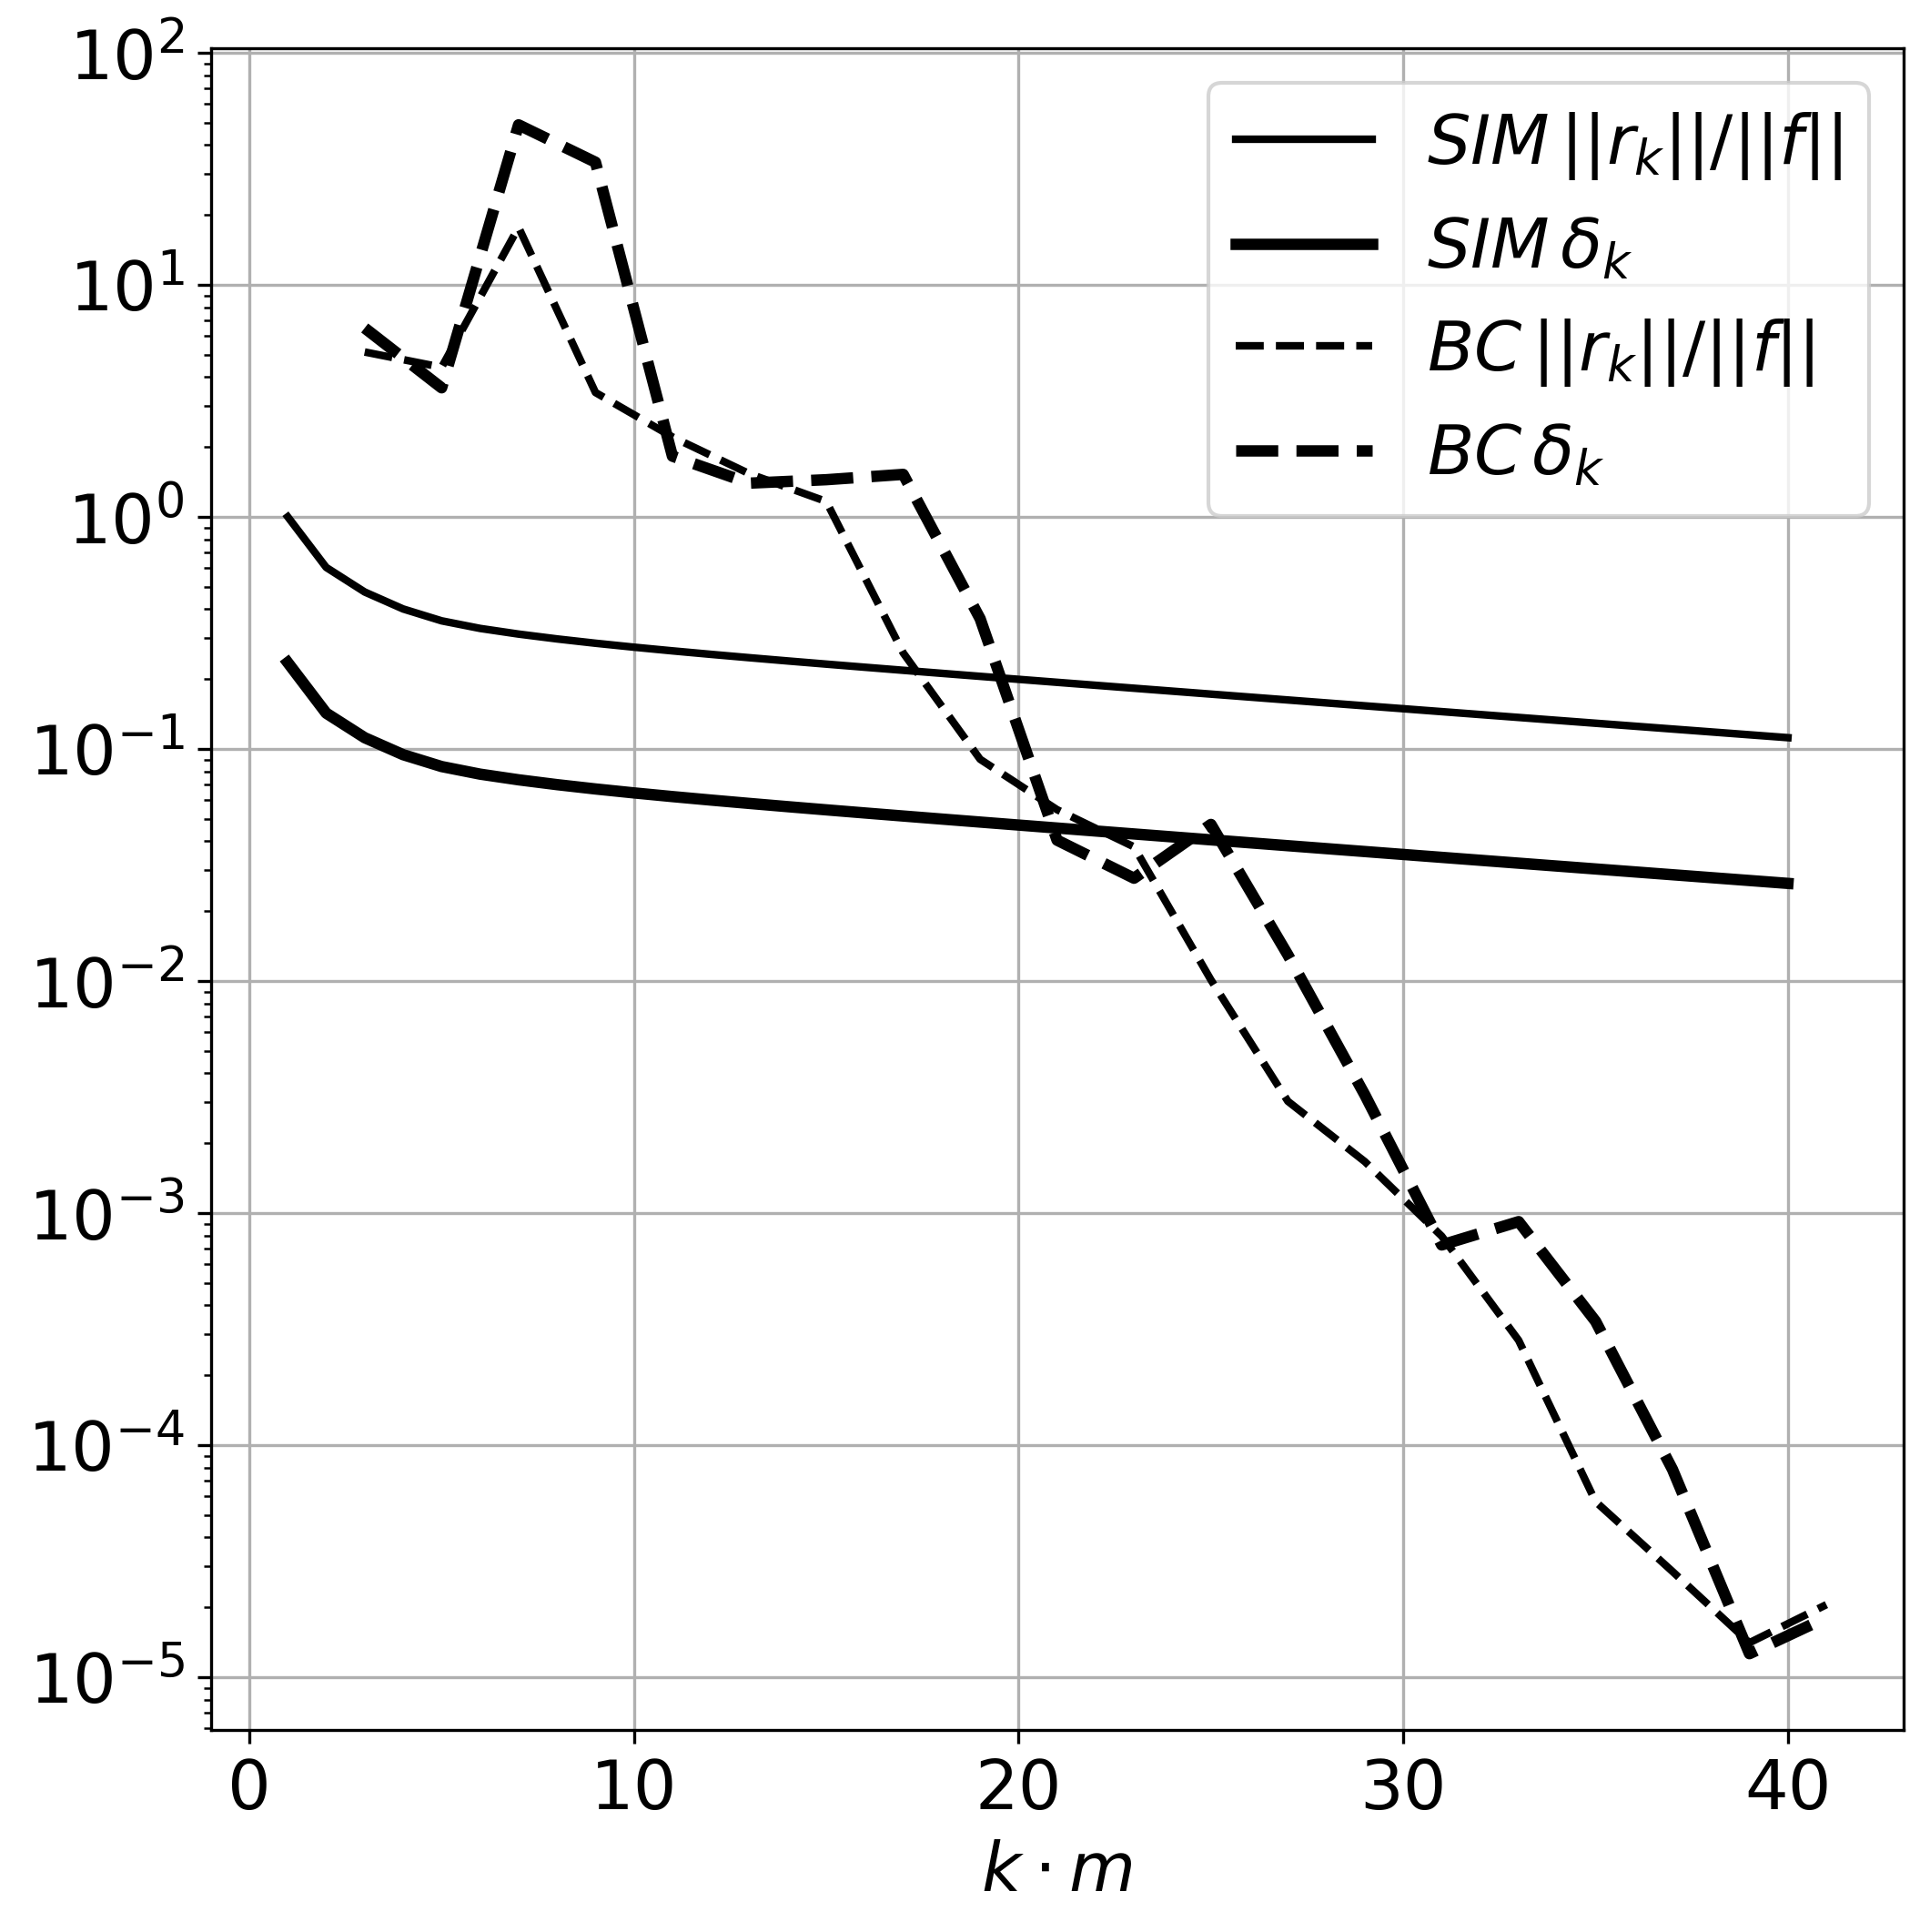

In [254]:
# Отрисовка результатов итераций на малой сетке при найденном параметре
plt.figure(figsize=(8,8), dpi=300)
plt.plot(iters_EM, resid_EM, label=r"$SIM\, ||r_k|| / ||f||$", linewidth=2, c="black")
plt.plot(iters_EM, delta_EM, label=r"$SIM\, \delta_k$", linewidth=3, linestyle="-", c="black")
plt.plot(iters_BS[1:], resid_BS[1:], label=r"$BC\, ||r_k|| / ||f||$", linewidth=2, linestyle="--", c="black")
plt.plot(iters_BS[1:], delta_BS[1:], label=r"$BC\, \delta_k$", linewidth=3, linestyle="--", c="black")
plt.yscale('log')
plt.xlabel(r"$k \cdot m$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(9, 7), dpi=300)
plt.contourf(np.abs(result_EM.reshape(N+[3]))[n_2//2, :, :, 0].real, 30, cmap="gray")
plt.colorbar()

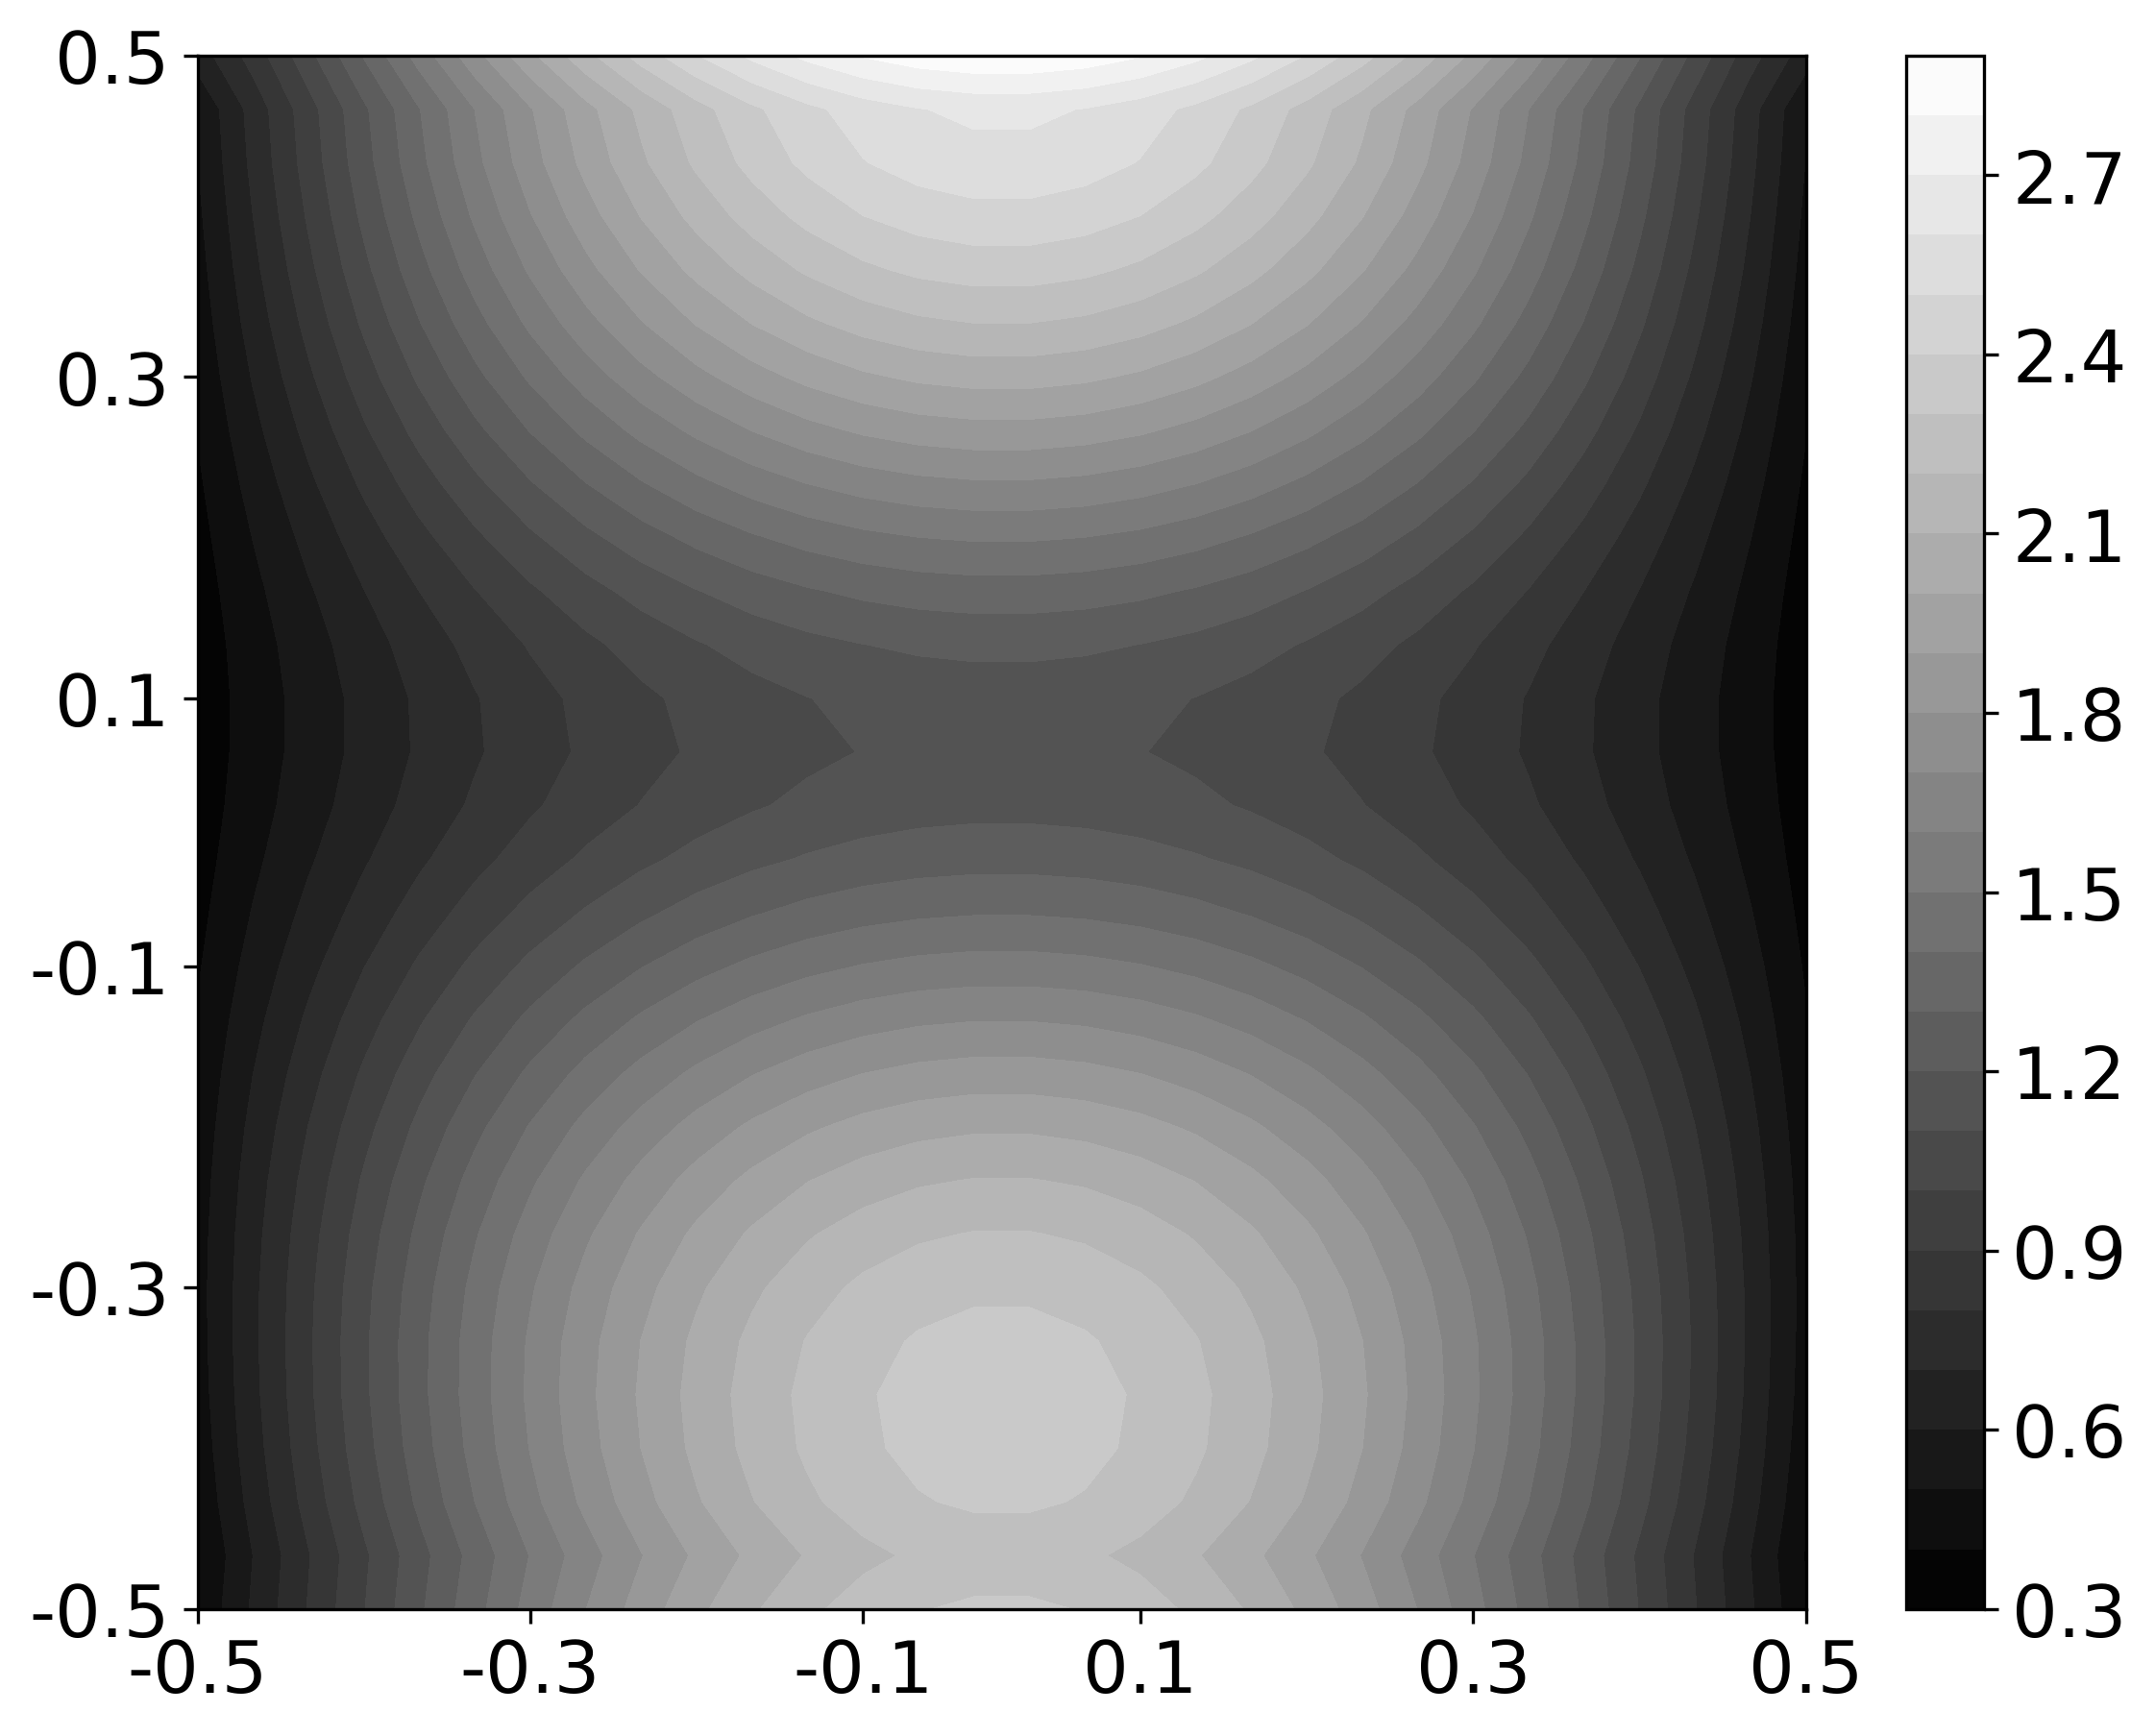

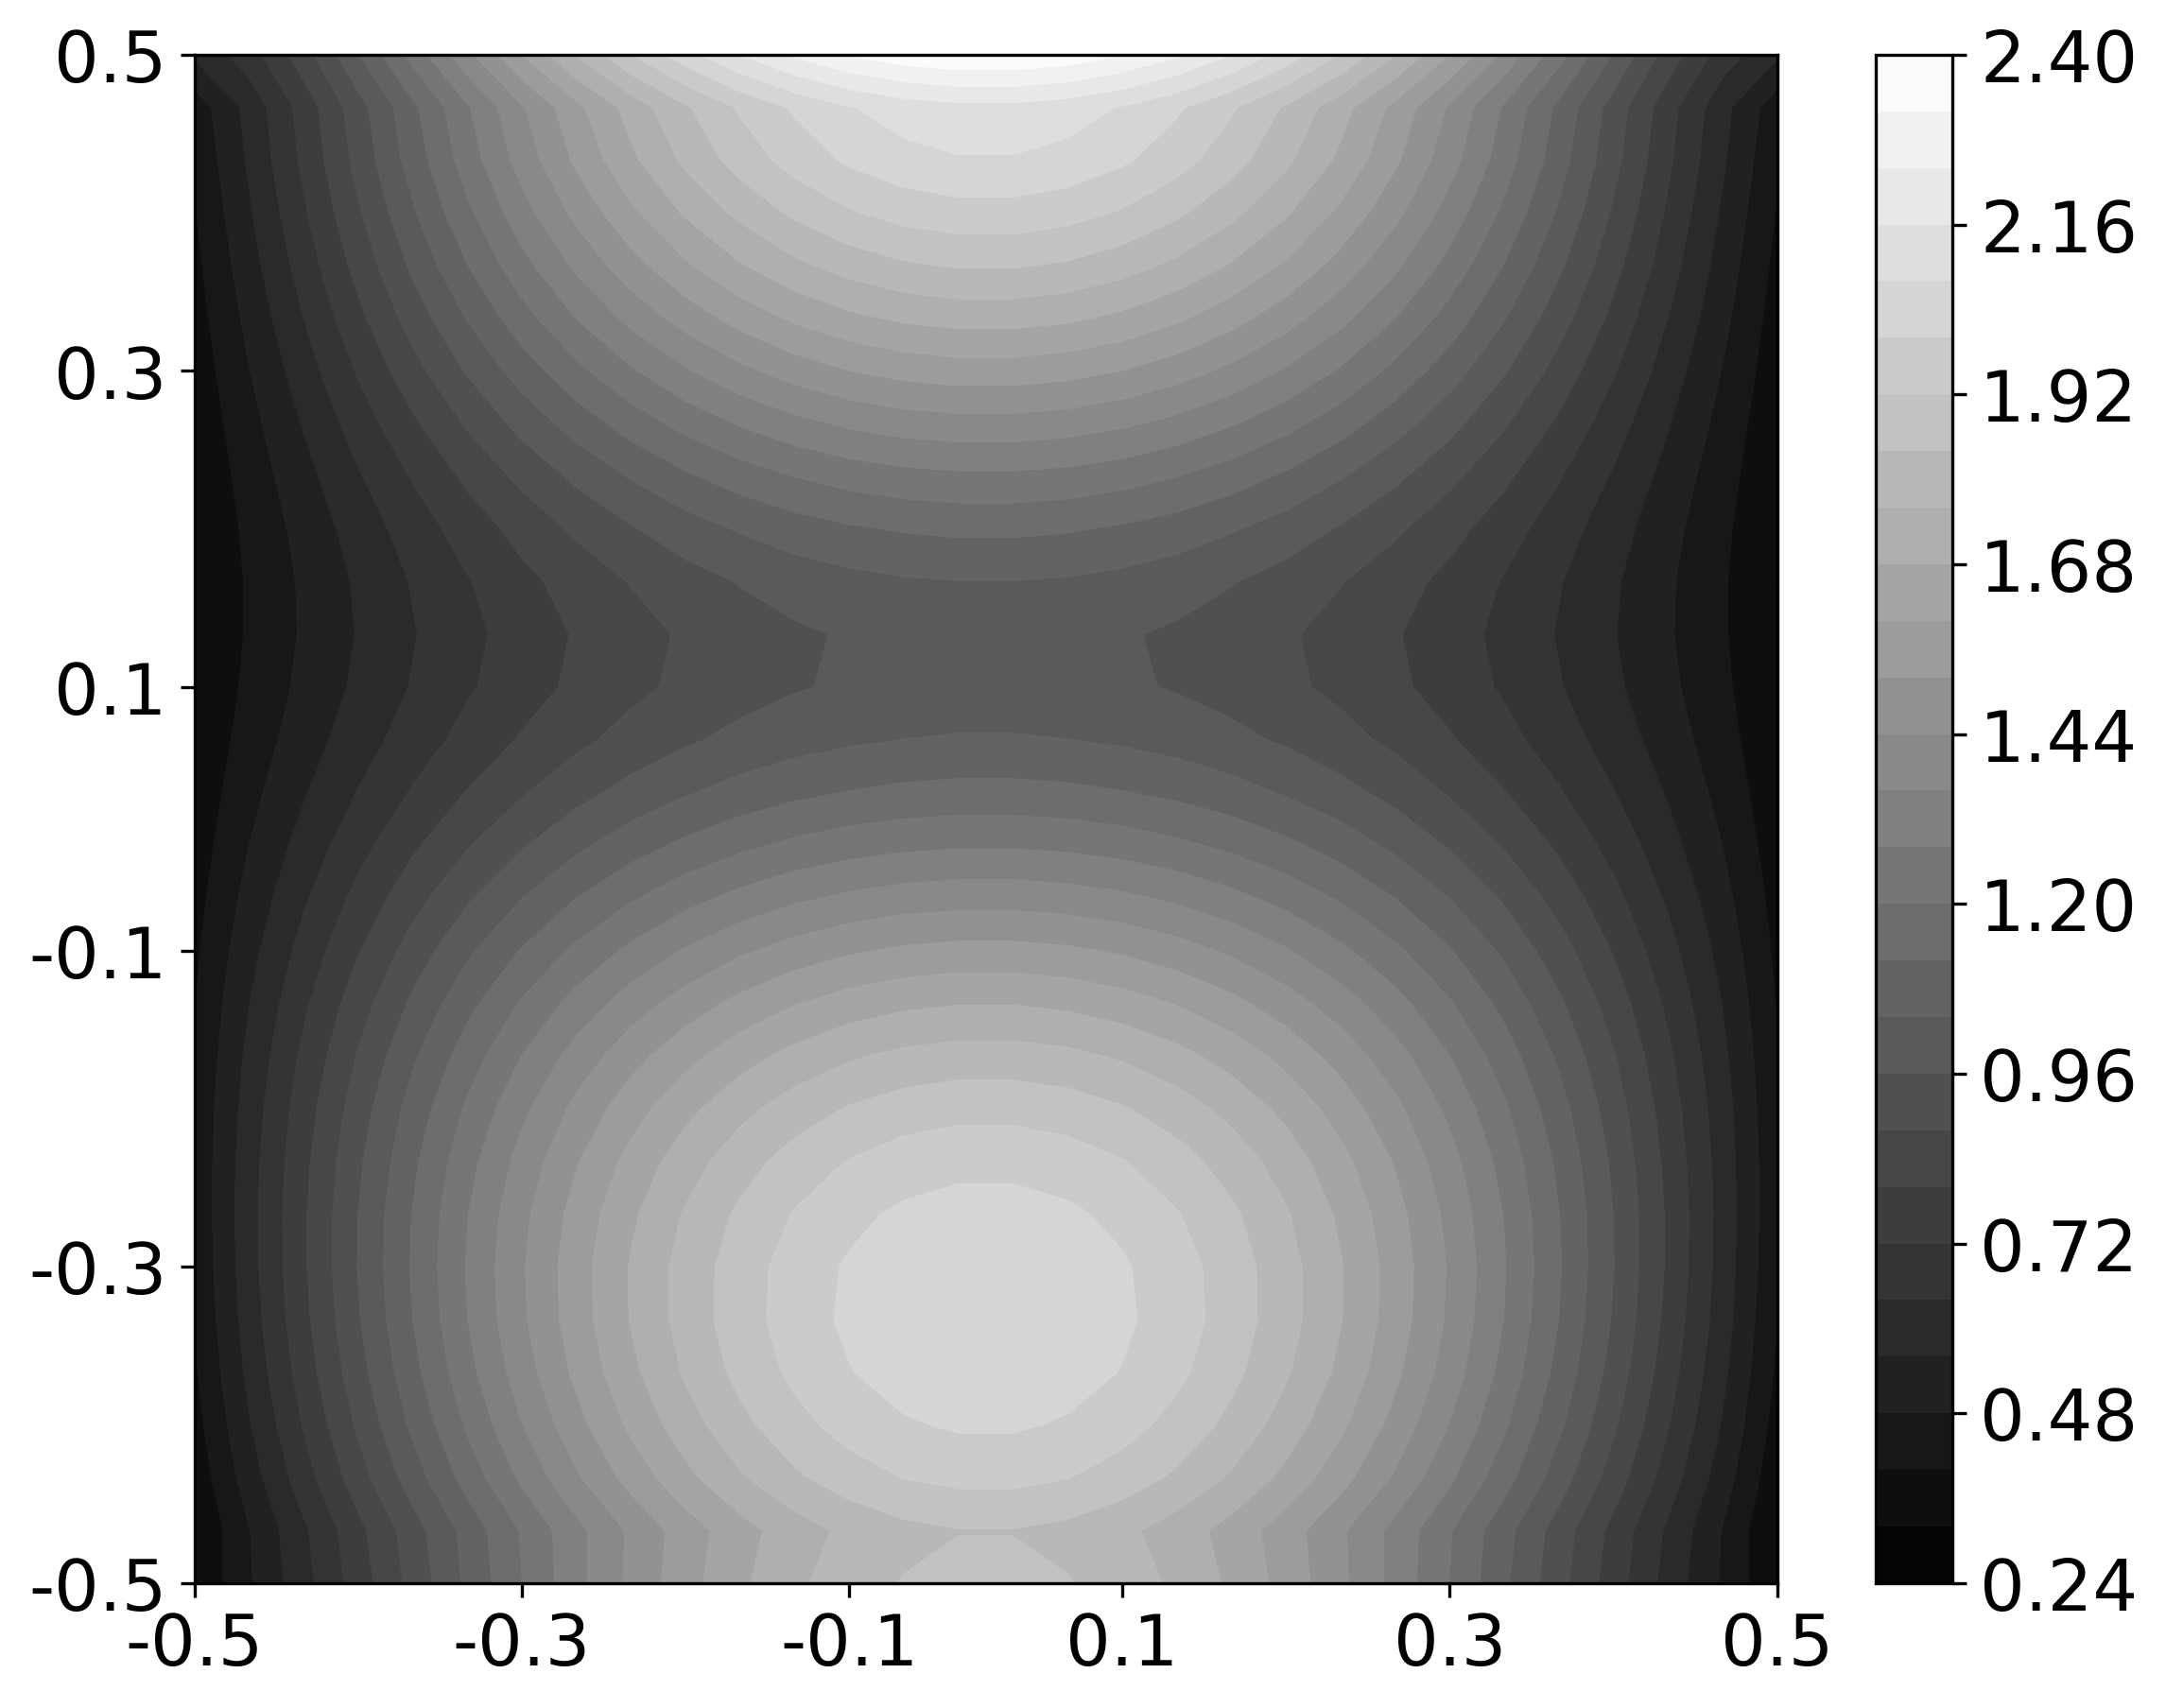

In [253]:
plt.figure(figsize=(9, 7), dpi=300)
plt.contourf(np.abs(result_EM.reshape(N+[3]))[n_2//2, :, :, 0].real, 30, cmap="gray")
plt.xticks(np.linspace(0, n_1-1, 6).round(0), np.linspace(-0.5, 0.5, 6).round(1), fontsize=18)
plt.yticks(np.linspace(0, n_1-1, 6).round(0), np.linspace(-0.5, 0.5, 6).round(1), fontsize=18)
plt.colorbar()

plt.figure(figsize=(9, 7), dpi=300)
plt.contourf(np.abs(result_BS.reshape(N+[3]))[n_2//2, :, :, 0].real, 30, cmap="gray")
plt.xticks(np.linspace(0, n_1-1, 6).round(0), np.linspace(-0.5, 0.5, 6).round(1), fontsize=18)
plt.yticks(np.linspace(0, n_1-1, 6).round(0), np.linspace(-0.5, 0.5, 6).round(1), fontsize=18)
plt.colorbar()

# ЭПР для решения ОМПИ

In [244]:
sigmas, angles = compute_RCS(result_EM, eta, grid, ind, volume, k, 300)

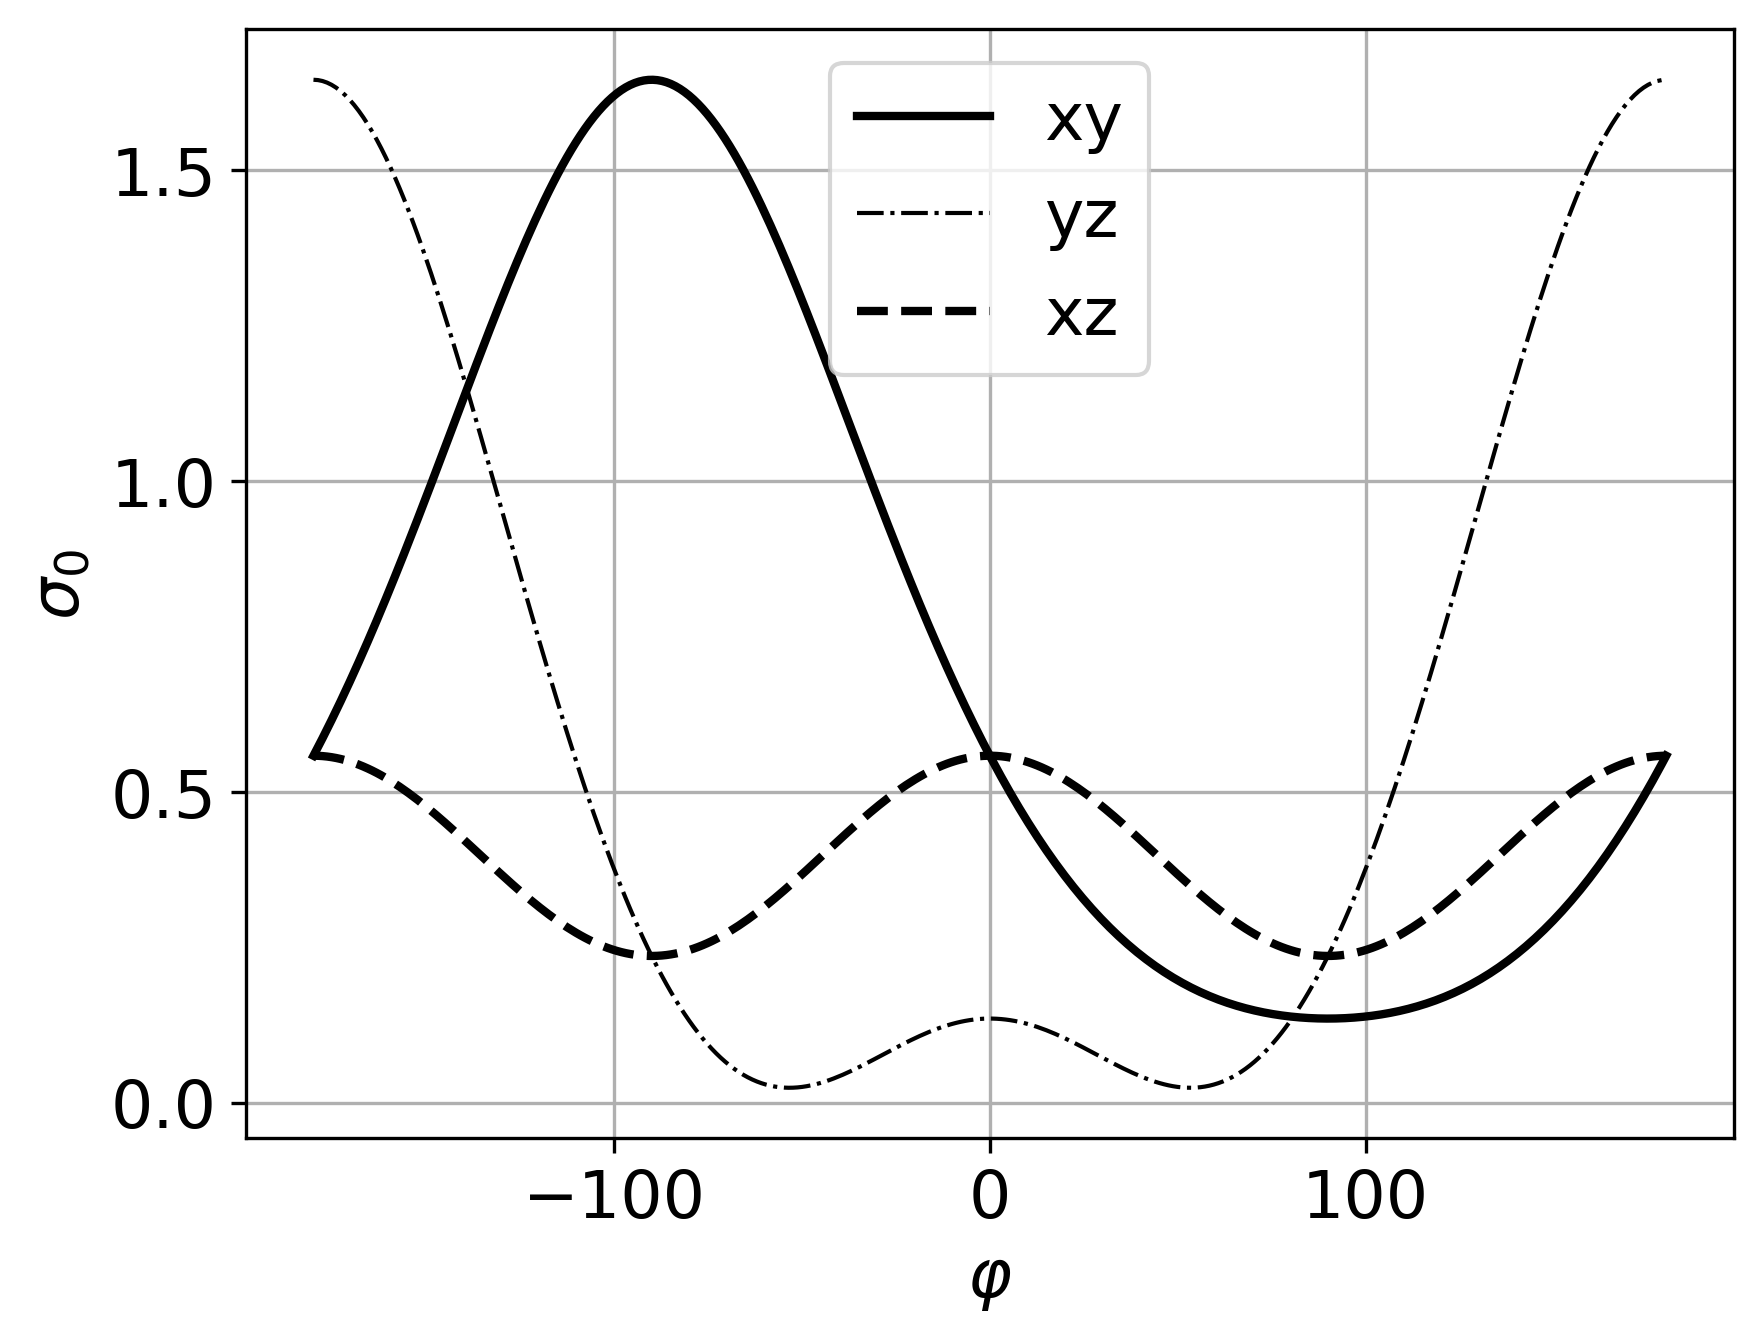

In [245]:
plt.figure(dpi=300)
plt.plot(angles[0] / np.pi * 180, 
         sigmas[0], 
         label="xy", linewidth=2, linestyle="-", c= "black")
plt.plot(angles[1] / np.pi * 180, 
         sigmas[1], 
         label="yz", linewidth=1, linestyle="-.", c= "black")
plt.plot(angles[2] / np.pi * 180, 
         sigmas[2], 
         label="xz", linewidth=2, linestyle="--", c= "black")
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r"$\varphi$", fontsize=fs)
plt.ylabel(r"$\sigma_0$", fontsize=fs)
plt.grid()

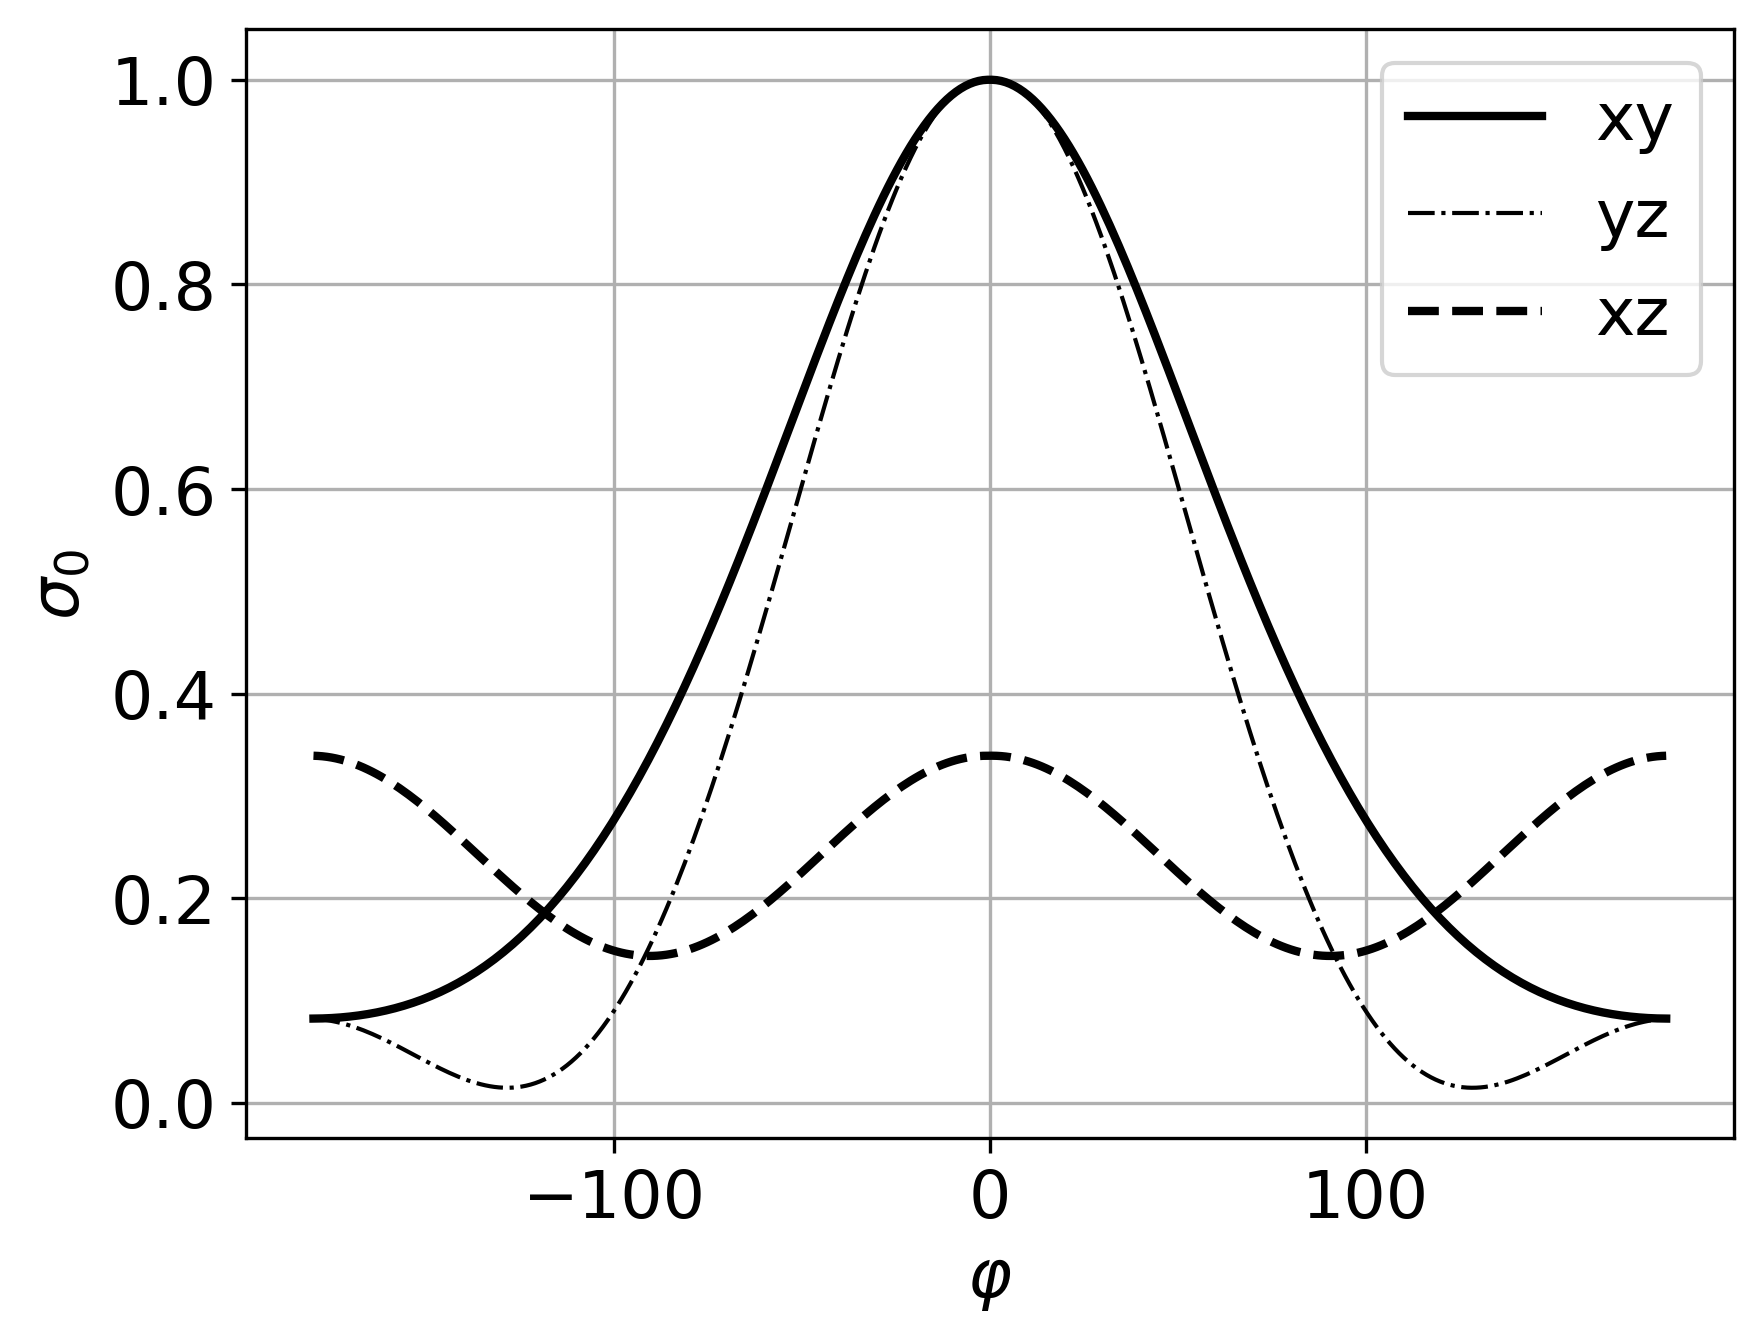

In [246]:
fs = 16

sigmas = [sigmas[0]/np.max(sigmas), sigmas[1]/np.max(sigmas), sigmas[2]/np.max(sigmas)]
rotated = [list(sigmas[0][np.argmax(sigmas[0]) - len(sigmas[0])//2:]) + list(sigmas[0][:np.argmax(sigmas[0]) - len(sigmas[0])//2]),
          list(sigmas[1][np.argmax(sigmas[1]) - len(sigmas[0])//2:]) + list(sigmas[1][:np.argmax(sigmas[1]) - len(sigmas[0])//2]),
          list(sigmas[2][np.argmax(sigmas[2]) - len(sigmas[0])//2:]) + list(sigmas[2][:np.argmax(sigmas[2]) - len(sigmas[0])//2])]
rotated_a = [list(rotated[0][len(rotated[0])//2:][::-1]) + list(rotated[0][len(rotated[0])//2:]),
            list(rotated[1][len(rotated[1])//2:][::-1]) + list(rotated[1][len(rotated[1])//2:]),
            list(rotated[2][len(rotated[2])//2:][::-1]) + list(rotated[2][len(rotated[2])//2:])]                                                        
plt.figure(dpi=300)
plt.plot(angles[0] / np.pi * 180, 
         rotated_a[0], 
         label="xy", linewidth=2, linestyle="-", c= "black")
plt.plot(angles[1] / np.pi * 180, 
         rotated_a[1], 
         label="yz", linewidth=1, linestyle="-.", c= "black")
plt.plot(angles[2] / np.pi * 180, 
         rotated_a[2], 
         label="xz", linewidth=2, linestyle="--", c= "black")
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r"$\varphi$", fontsize=fs)
plt.ylabel(r"$\sigma_0$", fontsize=fs)
plt.grid()

In [247]:
dataframe = pd.DataFrame({"iters": iters_EM,
                          "delta": delta_EM,
                          "resid": resid_EM})
dataframe.to_csv("dump_files/EXP_no_3/iters_history.csv")
np.save("dump_files/EXP_no_3/result_SIM", result_EM)
np.save("dump_files/EXP_no_3/grid", grid)

In [181]:
result_load = np.load("dump_files/EXP_no_1/result_SIM.npy")

# ЭПР для решения BISGStab

In [248]:
sigmas, angles = compute_RCS(result_BS, eta, grid, ind, volume, k, 300)

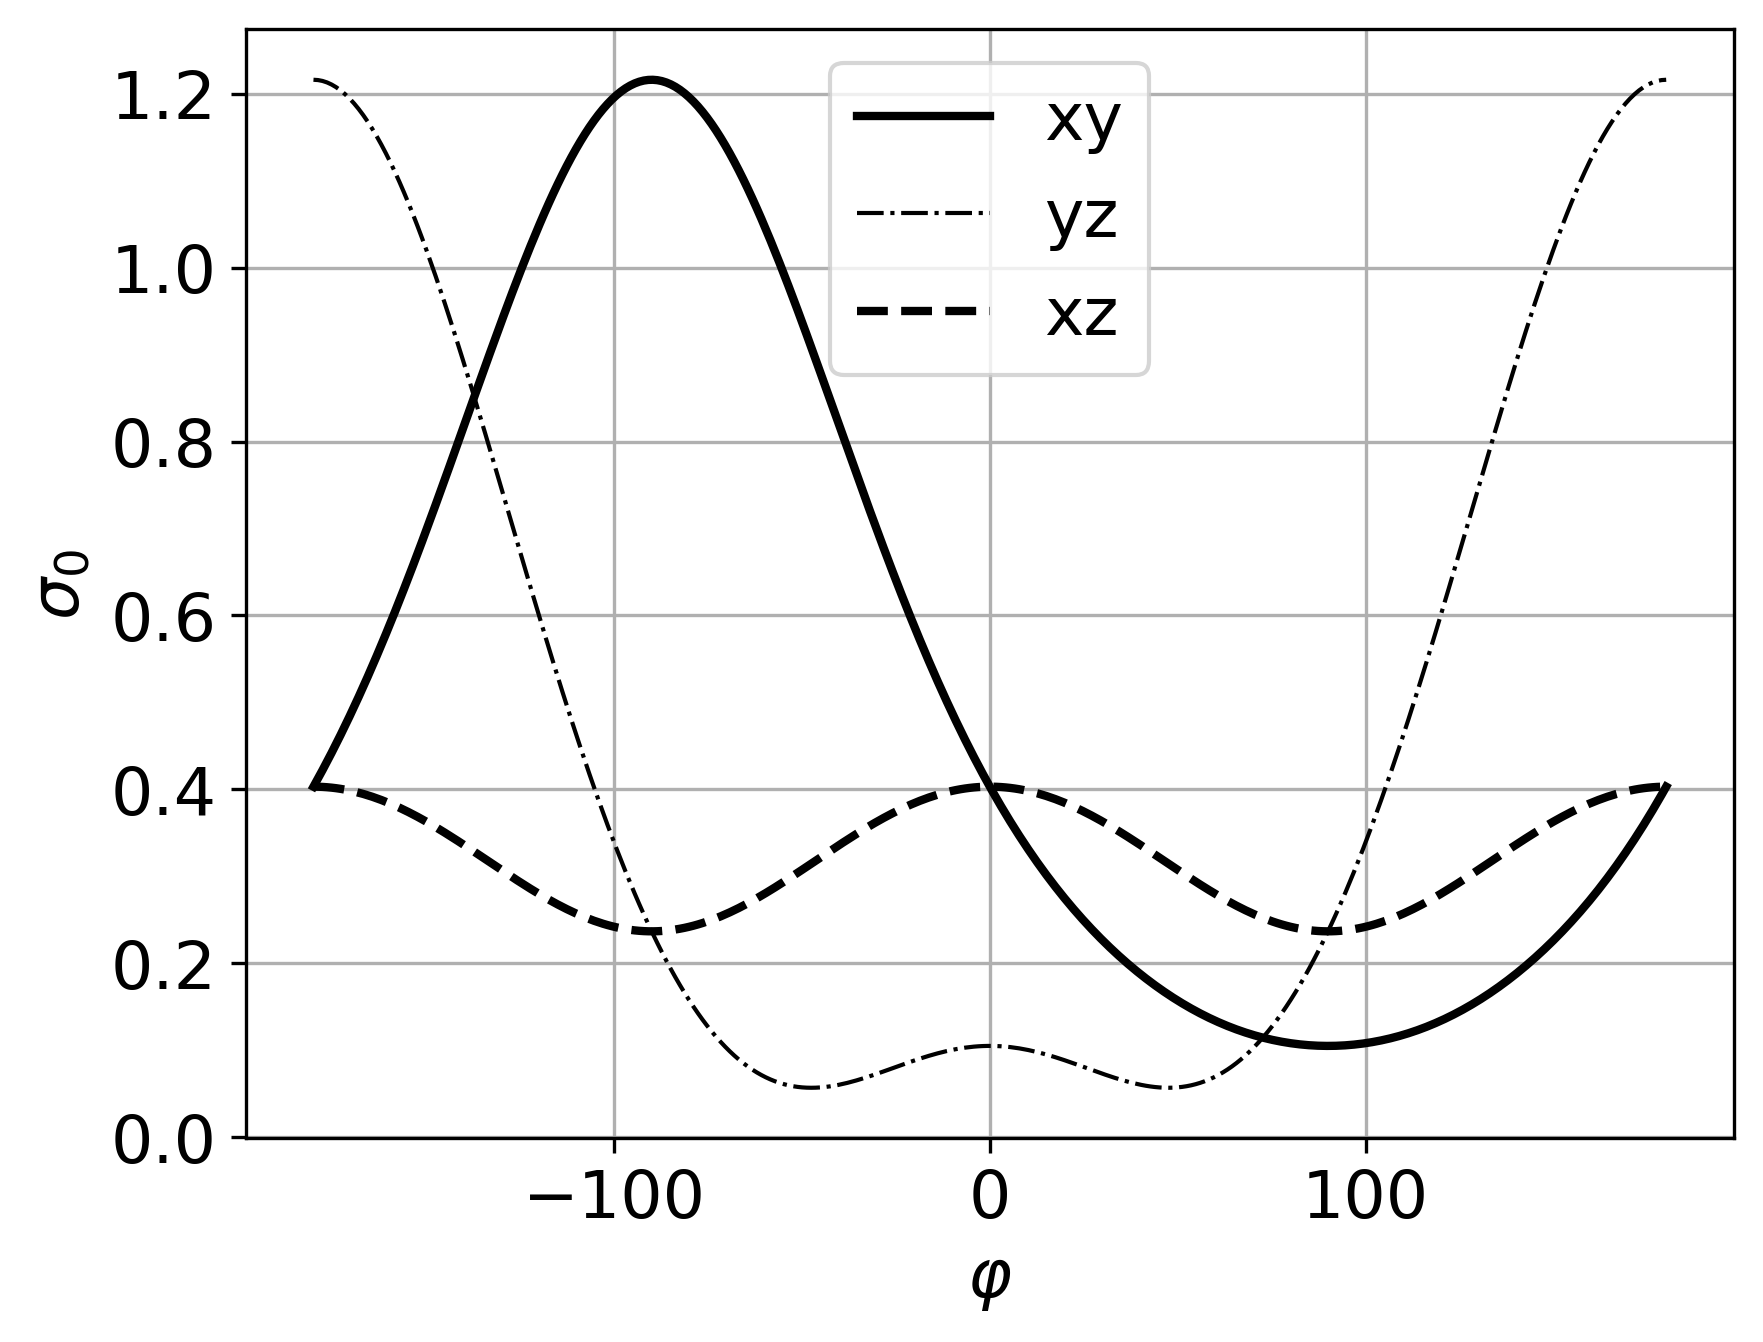

In [249]:
plt.figure(dpi=300)
plt.plot(angles[0] / np.pi * 180, 
         sigmas[0], 
         label="xy", linewidth=2, linestyle="-", c= "black")
plt.plot(angles[1] / np.pi * 180, 
         sigmas[1], 
         label="yz", linewidth=1, linestyle="-.", c= "black")
plt.plot(angles[2] / np.pi * 180, 
         sigmas[2], 
         label="xz", linewidth=2, linestyle="--", c= "black")
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r"$\varphi$", fontsize=fs)
plt.ylabel(r"$\sigma_0$", fontsize=fs)
plt.grid()

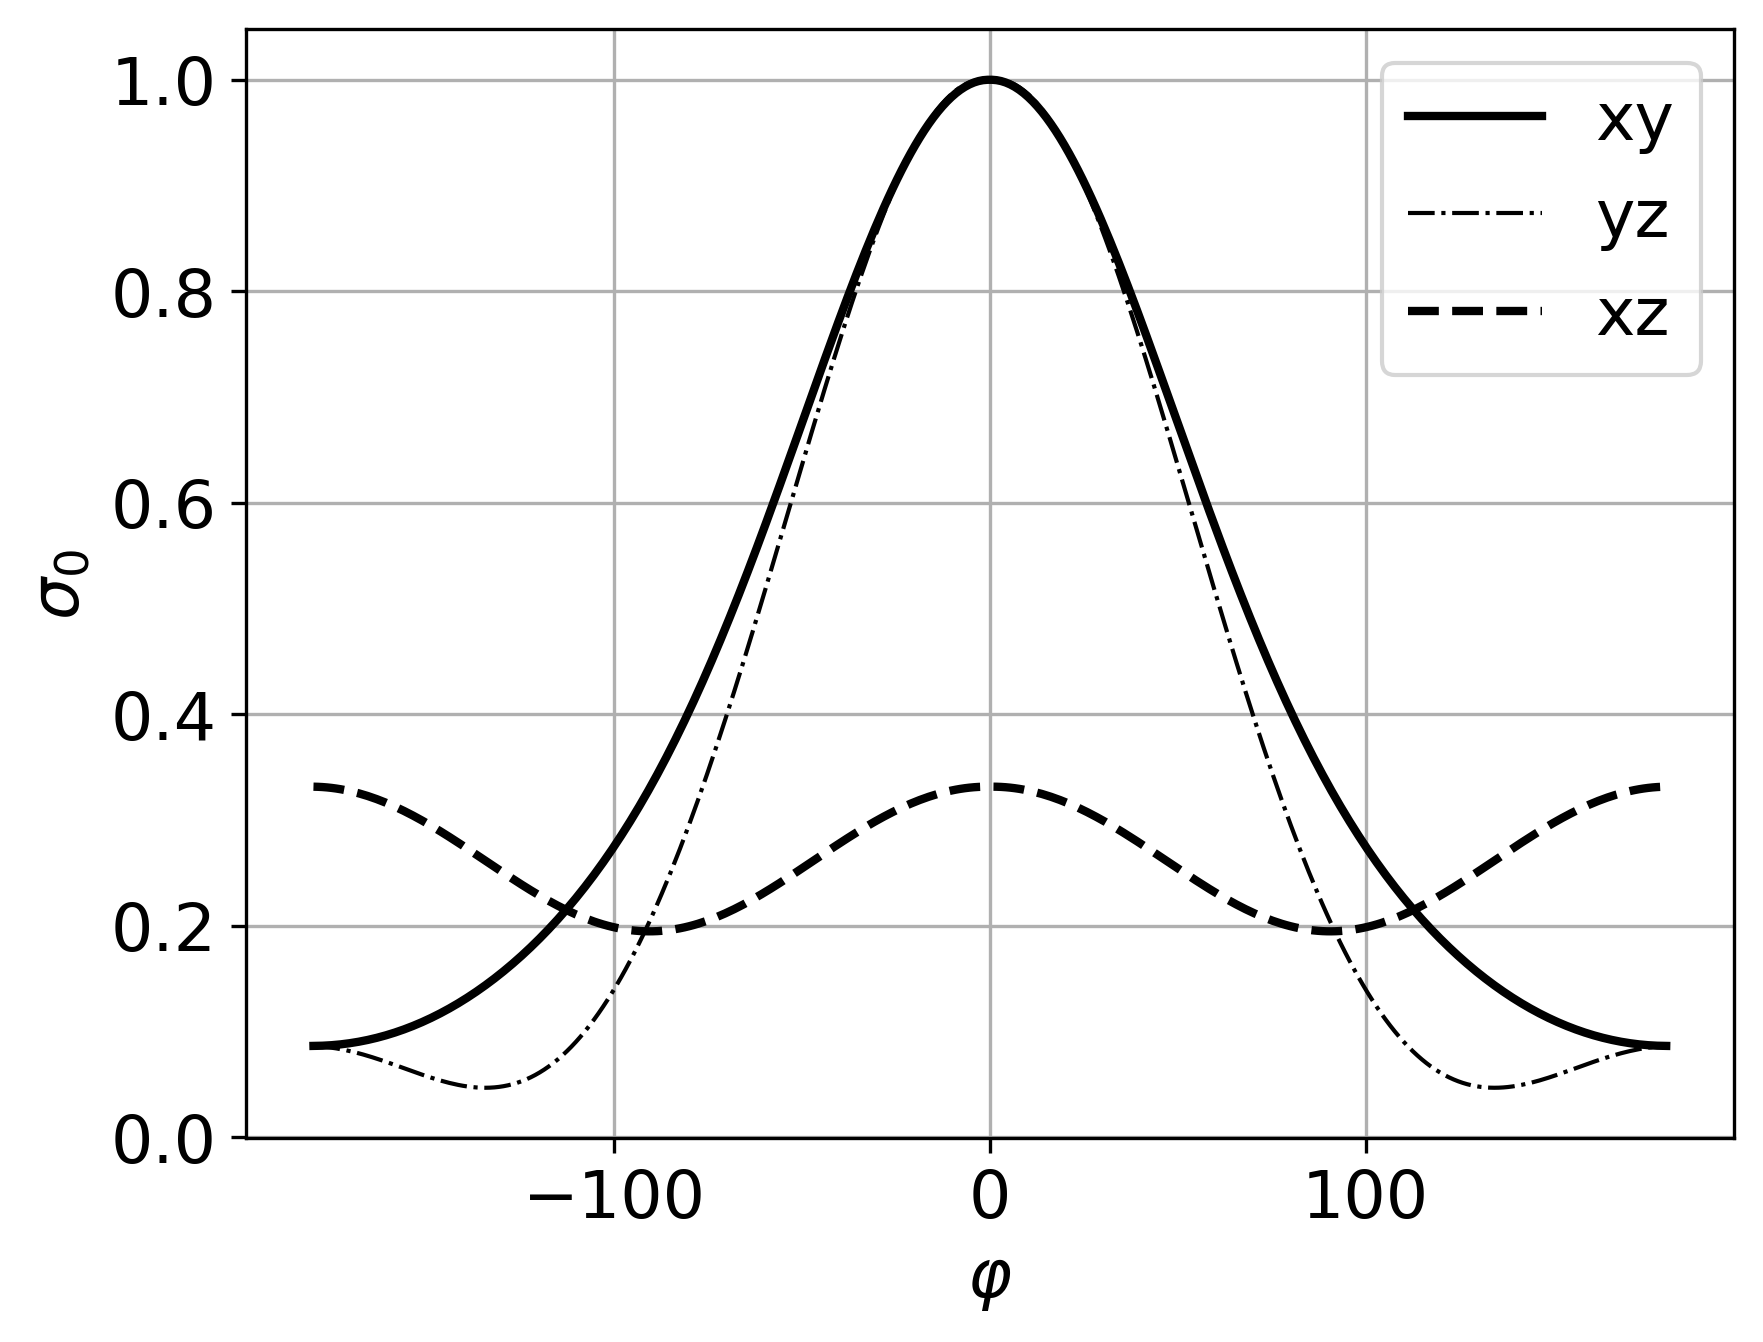

In [250]:
fs = 16

sigmas = [sigmas[0]/np.max(sigmas), sigmas[1]/np.max(sigmas), sigmas[2]/np.max(sigmas)]
rotated = [list(sigmas[0][np.argmax(sigmas[0]) - len(sigmas[0])//2:]) + list(sigmas[0][:np.argmax(sigmas[0]) - len(sigmas[0])//2]),
          list(sigmas[1][np.argmax(sigmas[1]) - len(sigmas[0])//2:]) + list(sigmas[1][:np.argmax(sigmas[1]) - len(sigmas[0])//2]),
          list(sigmas[2][np.argmax(sigmas[2]) - len(sigmas[0])//2:]) + list(sigmas[2][:np.argmax(sigmas[2]) - len(sigmas[0])//2])]
rotated_a = [list(rotated[0][len(rotated[0])//2:][::-1]) + list(rotated[0][len(rotated[0])//2:]),
            list(rotated[1][len(rotated[1])//2:][::-1]) + list(rotated[1][len(rotated[1])//2:]),
            list(rotated[2][len(rotated[2])//2:][::-1]) + list(rotated[2][len(rotated[2])//2:])]                                                        
plt.figure(dpi=300)
plt.plot(angles[0] / np.pi * 180, 
         rotated_a[0], 
         label="xy", linewidth=2, linestyle="-", c= "black")
plt.plot(angles[1] / np.pi * 180, 
         rotated_a[1], 
         label="yz", linewidth=1, linestyle="-.", c= "black")
plt.plot(angles[2] / np.pi * 180, 
         rotated_a[2], 
         label="xz", linewidth=2, linestyle="--", c= "black")
plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel(r"$\varphi$", fontsize=fs)
plt.ylabel(r"$\sigma_0$", fontsize=fs)
plt.grid()

In [251]:
dataframe = pd.DataFrame({"iters": iters_BS,
                          "delta": delta_BS,
                          "resid": resid_BS})
dataframe.to_csv("dump_files/EXP_no_3/iters_history_BS.csv")
np.save("dump_files/EXP_no_3/result_BS", result_BS)
np.save("dump_files/EXP_no_3/grid", grid)